In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle

from feature_engine.imputation import MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.discretisation.arbitrary import ArbitraryDiscretiser
from feature_engine.selection import DropFeatures
from feature_engine.encoding import MeanEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler , MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.pipeline import Pipeline 

s_path = os.path.dirname(os.path.realpath(__file__))
sys.path.append(s_path)

pd.set_option('display.max_columns',100)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import tm_teoriaMvto_base_prep as base_prep
import tm_teoriaMvto_label as tm_label
import tm_teoriaMvto_train as tm_train
import tm_teoriaMvto_ft_eng as ft_eng
# import tm_teoriaMvto_ft_sel as ft_sel

# models to test
from sklearn.svm import SVC
import xgboost as xgb


In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Desktop\Anaconda3\envs\n

In [2]:
path_files = os.path.join(s_path, 'historical_files')

# base prep control
EXPORT_X = False
EXPORT_Y = False

# params labeling
s_prefix = 'ft_'
s_lbl_type = 'c_binary'
f_th = 0.2
b_dist = True
b_percent = True
b_custom = True

# params loading
s_regime = 'mi_up'



In [3]:
if EXPORT_X:
  df_data = base_prep.import_sampling(path_files= os.path.join(path_files, 'FeaturesFiles'), prefix_files= s_prefix)

  # create new features before extracting samples - using full data needed by lag features
  df_data = ft_eng.BasicFeatures().transform(X=df_data)

  df_X = base_prep.ft_export(df_data, path_files= os.path.join(path_files, 'TrainFiles'), prefix= s_prefix)
  y_sc = base_prep.y_export(df_data, path_files= os.path.join(path_files, 'TrainFiles'), prefix= s_prefix)



In [4]:
y_config = 'prefix_'+ s_prefix +'_type_'+ s_lbl_type +'_th_'+ str(f_th) +'_dist_'+ str(b_dist) +'_percent_'+str(b_percent)+'_custom_'+str(b_custom)

if EXPORT_Y:
  df_label = None 
  if EXPORT_X: df_label = y_sc

  # specify df_data = None (default) to load pickle from s_path + 'y_prep_data.pkl'
  label = tm_label.Labeling(df_data = df_label, label_type= s_lbl_type, b_dist_to_high= b_dist, 
                            s_path = os.path.join(path_files, 'TrainFiles'), prefix_files = s_prefix, th_label_y1=f_th, 
                            b_percent_freq=b_percent, b_custom_dir=b_custom)

  df_y = label.apply_label(s_model_return = s_regime)  # it will export 4 pickle files to label_obj.s_path
  # y_config = label.s_name

y_outfile = os.path.join(os.path.join(path_files, 'TrainFiles'), 'y_' + y_config +'.pkl')

if os.path.exists(y_outfile):
  print('y outfile ready for configuration: {}'.format(y_config))
else:
  print('WARNING: y outfile not found for configuration. Define EXPORT_Y = True and try again {}'.format(y_config))



y outfile ready for configuration: prefix_ft__type_c_binary_th_0.2_dist_True_percent_True_custom_True


In [5]:
l_prop_08 = ['escora_bid_2.5_0.8', 'escora_ask_2.5_0.8', 'escora_bid_3.5_0.8', 
            'escora_ask_3.5_0.8', 'escora_bid_4.5_0.8', 'escora_ask_4.5_0.8', ]

l_prop_12 = ['escora_bid_2.5_1.2', 'escora_ask_2.5_1.2', 'escora_bid_3.5_1.2',
            'escora_ask_3.5_1.2', 'escora_ask_4.5_1.2', 'escora_bid_4.5_1.2', ]

l_prop_2 = [ 'escora_bid_2.5_2', 'escora_ask_2.5_2', 'escora_bid_3.5_2',
            'escora_ask_3.5_2', 'escora_bid_4.5_2', 'escora_ask_4.5_2', ]

l_col_log = ['agg_net_d', 'aggbig_net_d', 'vol_trd', 'vol_big', 'big_v', 'vol_trd_aux', 
   'vol_big_aux', 'big_v_aux', 'loc_agg_net_d', 'big_c', 'big_c_aux',
   'loc_aggbig_net_d', 'agg_net_m', 'agg_net_m_aux', 'abagg', 'abagg_aux',
   'aggbig_net_m', 'aggbig_net_m_aux', 'loc_agg_net_m', 'loc_aggbig_net_m',
   'loc_agg_net_m_aux', 'loc_aggbig_net_m_aux', 'loc_aggbig_c_m', 'loc_aggbig_v_m', 
   'loc_aggbig_c_m_aux', 'loc_aggbig_v_m_aux', 'abs_v', 'abs_c', 'aggpior_v', 'aggpior_v_aux', 
   'aggpior_c', 'aggpior_c_aux', 'agg_net_10', 'agg_net_40', 'agg_net_80', 'loc_agg_net_10',
   'aggbig_net_10', 'aggpior_DIF', 'aggpior_DIF_30', 'abs_DIF', 'abs_DIF_30',
   'abagg_10', 'aggpior_aux_DIF', ]

l_side_drop = ['big_c','big_v','aggpior_c','aggpior_v','loc_aggbig_c_m','loc_aggbig_v_m','pagg_c_best',
  'pagg_c_best_0.5','pagg_c_best_0.7','pagg_c_best_0.9','pagg_v_best','pagg_v_best_0.5','pagg_v_best_0.7',
  'pagg_v_best_0.9','abs_c','abs_v','int_c','int_c_0.6','int_c_0.7','int_c_0.8','int_c_0.9','int_dif_c',
  'int_v','int_v_0.6','int_v_0.7','int_v_0.8','int_v_0.9','int_dif_v','imp_c','imp_c_0.6','imp_c_0.7',
  'imp_c_0.8','imp_c_0.9','imp_v','imp_v_0.6','imp_v_0.7','imp_v_0.8','imp_v_0.9','escora_bid_2.5_1.2',
  'escora_bid_2.5_2','escora_ask_2.5_1.2','escora_ask_2.5_2','escora_bid_3.5_1.2','escora_bid_3.5_2',
  'escora_ask_3.5_1.2','escora_ask_3.5_2','escora_bid_4.5_0.8','escora_bid_4.5_2','escora_ask_4.5_0.8',
  'escora_ask_4.5_2','movesc_bid_2.5','movesc_ask_2.5','movesc_bid_2.5_0.5','movesc_ask_2.5_0.5',
  'movesc_bid_2.5_0.7','movesc_ask_2.5_0.7','movesc_bid_3.5','movesc_ask_3.5','movesc_bid_3.5_0.7',
  'movesc_ask_3.5_0.7','movesc_bid_3.5_0.9','movesc_ask_3.5_0.9','movesc_bid_4.5','movesc_ask_4.5',
  'movesc_bid_4.5_0.5','movesc_ask_4.5_0.5','movesc_bid_4.5_0.7','movesc_ask_4.5_0.7','depth_bid7','depth_ask7'
  ]

l_side_drop_aux = ['big_c_aux','big_v_aux','aggpior_c_aux','aggpior_v_aux','loc_aggbig_c_m_aux',
  'loc_aggbig_v_m_aux','pagg_c_best_aux','pagg_c_best_0.5_aux','pagg_c_best_0.7_aux',
  'pagg_c_best_0.9_aux','pagg_v_best_aux','pagg_v_best_0.5_aux', 'pagg_v_best_0.7_aux',
  'pagg_v_best_0.9_aux'
  ]

l_ft_aux = [
  'vol_trd_aux', 'n_trd_aux','vol_big_aux','n_big_aux','vol_big_ratio_aux','big_c_aux','big_v_aux',
  'aggpior_c_aux','aggpior_v_aux','aggimb_aux','aggimb_big_aux','n_aggimb_aux','agg_net_m_aux',
  'aggbig_net_m_aux','loc_aggbig_c_m_aux','loc_aggbig_v_m_aux','loc_agg_net_m_aux','loc_aggbig_net_m_aux',
  'loc_agg_imb_m_aux','loc_aggbig_imb_m_aux','pagg_c_best_aux','pagg_c_best_0.5_aux','pagg_c_best_0.7_aux',
  'pagg_c_best_0.9_aux','pagg_v_best_aux','pagg_v_best_0.5_aux','pagg_v_best_0.7_aux','pagg_v_best_0.9_aux',
  'abagg_aux','n_p_aux','aggpior_aux_DIF','pagg_aux_DIF'
  ]



In [6]:
test_size = 0.2

if not EXPORT_X:
  df_X = tm_train.load_models('X_samples_'+s_prefix, os.path.join(path_files, 'TrainFiles'))  # search for path_files/s_regime.pkl

X = df_X.loc[df_X['model'] == s_regime].drop(columns='model')

if not EXPORT_Y:
  df_y = tm_train.load_models('y_' + y_config, os.path.join(path_files, 'TrainFiles'))
  y = df_y.loc[df_y['model'] == s_regime].drop(columns='model')
else:
  y = df_y.drop(columns='model')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)

print('load_split: X, y data load and split complete!')



load_split: X, y data load and split complete!


In [7]:
# DEBUG: prop_features contaning np.NaN = (pd.isna(X_train).sum()>0).sort_values(ascending=False).head(50)
X_train = ft_eng.PropImputer(0.8, l_prop_08).transform(X_train)
X_train = ft_eng.PropImputer(1.2, l_prop_12).transform(X_train)
X_train = ft_eng.PropImputer(2, l_prop_2).transform(X_train)

median_inputer = MeanMedianImputer(variables=['PA_down',])
X_train = median_inputer.fit_transform(X_train)

nan_imputer = ArbitraryNumberImputer(0.0, variables=['ohlc_10','ohlc_50'])
X_train = nan_imputer.fit_transform(X_train)

X_train = ft_eng.DifAll().transform(X_train)
X_train = ft_eng.LogVolume(l_col_log).transform(X_train)

if s_regime[:2] == 'mw':
  # for now, removing all side columns
  l_cols_drop = l_side_drop + l_ft_aux + ['smart_price', 'sspread']
else:
  l_cols_drop = l_side_drop + l_side_drop_aux + ['s_run', 'n_p_aux', 'smart_price', 'sspread']

# TODO: INCREMENTAR L COLS DROP TAMBEM QUANDO LABEL NAO FOR DIST-TO-HIGH, RETIRANDO AS COLUNAS DE VARIACAO DE PRECO!

X_train.drop(columns=l_cols_drop, inplace=True)


In [8]:
X_test = ft_eng.PropImputer(0.8, l_prop_08).transform(X_test)
X_test = ft_eng.PropImputer(1.2, l_prop_12).transform(X_test)
X_test = ft_eng.PropImputer(2, l_prop_2).transform(X_test)

X_test = median_inputer.transform(X_test)

X_test = nan_imputer.transform(X_test)

X_test = ft_eng.DifAll().transform(X_test)
X_test = ft_eng.LogVolume(l_col_log).transform(X_test)

X_test.drop(columns=l_cols_drop, inplace=True)



In [9]:

# TODO: move function to ft_selection.py
def list_sub(lst1, lst2):
  final_list = list(set(lst1) - set(lst2))
  return final_list


def list_union(*l_lists):
  l_union = l_lists[0]
  if len(l_lists) > 1:
    for i in range(len(l_lists)-1):
      l_union = set(l_union) | set(l_lists[i+1])
  return list(l_union)

l_duplicate = ['loc_agg_net_m',]  # _2 ft comes from ft_eng.duplicate()

l_cap_1 = ['vewma_c_v', 'vewmag_dif', 'book_imb', 'book_imb_dif', ]

l_cap_5 = ['PA_up', 'PA_down', ]

l_cap_10 = ['n_big_aux', ]

l_cap_default = list_sub(X_train.columns.to_list(), list_union(l_cap_1, l_cap_5, l_cap_10))

l_bins_q2 = ['loc_agg_net_m_2',]  # _2 ft comes from ft_eng.duplicate()

l_bins_q4 = ['ohlc_10','ohlc_50',]

l_bins_q5 = ['loc_aggbig_net_m','chgfreq','vol_trd_aux','aggbig_net_m_aux','book_imb','rng_ewma_dif',
            'rng_ewma_dif_40','rng_ewma_dif_80','vewma_10','vewma_g_p_10','aggbig_net_10',
]

l_bins_q6 = ['agg_net_d', 'aggbig_net_d', 'loc_agg_imb_m_aux',]

l_bins_q8 = ['rng_ewma','vewma_g_p','vewmag_dif','n_trd_aux','abagg_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8',
            'escora_bid_3.5_0.8','escora_ask_3.5_0.8','escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_2.5_0.9',
            'movesc_ask_2.5_0.9','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','movesc_bid_4.5_0.9','movesc_ask_4.5_0.9',
            'msg_imb','rng_smart_10','imp_DIF_10','imp_DIF_50','agg_net_80','imp_FCAST_40','aggpior_DIF',
            'book_imb_mean_dif_cp','msg_imb_mean_10','escora_4.5_0.8_DIF',
]

l_bins_q10 = ['vol_big_ratio','aggimb','n_aggimb','agg_net_m','loc_aggbig_imb_m','abagg','n_p','vewma',
            'vewma_c_v', 'aggimb_aux','aggimb_big_aux','agg_net_m_aux','loc_aggbig_net_m_aux','smart_price_dif',
            'smart_price_50','rng_smart_50','agg_net_10','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10',
            'book_imb_mean_10','book_imb_mean_dif_lp','msg_imb_mean_40','msg_imb_mean_dif_lp','msg_imb_mean_dif_cp',
            'sspread_mean','movesc_2.5_0.7_DIF','msg_imb_mean_40_ABS','loc_agg_net_m',
] 

d_bins_arbitrary = {
            'n_trd':  [-0.01, 70, 180, 280, 380, 5000000],
            'vol_trd':  [0, 7.237, 7.55, 10000],
            'aggimb_big':		[-1.1, -0.4, 0.4, 1.1],
            'aggbig_net_m':		[-10000, -5, +10000],
            'last_d_s':		[-0.01, 0.167, 0.280, 1],
            'loc_agg_net_d':		[-10000, -6.4, 5.2, 5.7, 10000],
            'loc_aggbig_net_d':		[-10000, -5.4, -3.8, 10000],
            'n_big_aux':	[-0.01, 3.1, 100],
            'vol_big_ratio_aux':		[-0.01, 0.275, 0.520, 1.01],
            'loc_agg_net_m_aux':		[-10000, -4.451, -3.592, -2.435, 3.607, 10000] ,
            'loc_aggbig_imb_m_aux':		[-1.1, -0.99, -0.391, -0.0118, 0.4, 0.99, 1.1],
            'aggpior_DIF_30':		[-7.625, -4.454, -4.111, -3.829, -3.26, -3.05, -3.04, -0.01, 0.01, 3.714, 7.6],
            'abs_DIF':		[-7.037, -4.796, -4.19, -0.1, 0.1, 2.398, 4.564, 7.19],
            'pagg_DIF':	[-1.1, -0.95, -0.6, -0.4, -0.001, 0.001, 0.4, 0.6, 0.95, 1.1],
            'book_imb_dif':	[-1000, -27, -14, -6.8, -2.5, 0.1, 4.29, 11.2, 22, 1000],
            'book_imb_mean_40': [-1000, -30, -20, -16, 1000],
            'aggpior_aux_DIF':		[-7.625, -4.331, -3.584, -3.045, -0.01, 0.01, 3.045, 7.6] ,
            'pagg_aux_DIF':		[-1.1, -0.95, -0.5, -0.001, 0.001, 0.5, 0.95, 1.1],
            'escora_3.5_1.2_DIF':		[-0.5, -0.171, -0.0482, 0, 0.0482, 0.0927, 0.5],
            'movesc_3.5_0.7_DIF':		[-17.5, -4.451, -1.391, -0.146, 0.0, 0.312, 8],
            'book_imb_mean_dif_cp_ABS':		[-0.01, 0.119, 500],
            'msg_imb_mean_dif_lp_ABS':		[-0.01, 0.281, 1.1],
            'loc_agg_imb_m':  [-1.01, -0.491, -0.366, -0.288, -0.223, -0.167, 1.01],
            'imp_FCAST_10': [-10000, -3.012, -1.674, -0.653, 10000],
}

l_bins_nulls = ['vol_big','n_big','PA_up','PA_down','vol_big_aux','n_aggimb_aux','imp_DIF','int_DIF',
                'int_DIF_50','abs_DIF_30','msg_imb_dif','depth_DIF',
                'depth_DIF_10','book_imb_mean_us_5','book_imb_mean_us_20','sspread_mean_us_5',
                'escora_2.5_2_DIF','movesc_4.5_0.7_DIF', 
                # TODO: 's_run', 'n_p_aux' treat for MW
]

# ft classification based on mean encoding 
l_ft_alta = ['pagg_DIF','loc_agg_net_m_aux','aggpior_aux_DIF','loc_agg_imb_m','vol_big_ratio','aggimb',
             'n_aggimb','agg_net_m','loc_aggbig_imb_m','n_p','vewma','agg_net_m_aux','smart_price_dif',
             'smart_price_50','agg_net_10','msg_imb_mean_40_ABS','ohlc_10','ohlc_50','loc_aggbig_net_m',
             'vol_trd_aux','aggbig_net_m_aux','rng_ewma_dif_80','vewma_10','rng_ewma','vewma_g_p','vewmag_dif',
             'n_trd_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8','escora_bid_3.5_0.8','escora_ask_3.5_0.8'
             ,'escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','msg_imb','rng_smart_10',
]

l_ft_media = ['last_d_s','aggimb_big','loc_aggbig_imb_m_aux','pagg_aux_DIF','movesc_3.5_0.7_DIF','abs_DIF',
              'book_imb_mean_dif_cp_ABS''book_imb_dif','abagg','vewma_c_v','aggimb_aux','loc_aggbig_net_m_aux',
              'rng_smart_50','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10','msg_imb_mean_dif_cp',
              'sspread_mean','movesc_2.5_0.7_DIF','loc_agg_net_m','book_imb','rng_ewma_dif','rng_ewma_dif_40',
              'vewma_g_p_10','aggbig_net_10','vol_trd','loc_agg_imb_m_aux','movesc_bid_2.5_0.9','movesc_ask_2.5_0.9',
              'movesc_bid_4.5_0.9','movesc_ask_4.5_0.9','imp_DIF_10','imp_FCAST_40','aggpior_DIF','book_imb_mean_dif_cp',
              'msg_imb_mean_10',
]


In [10]:
pipe_cap_outliers = Pipeline([
                ('cap1', Winsorizer(variables=l_cap_1, capping_method='quantiles', fold = 0.01, tail = 'both')),
                ('cap5', Winsorizer(variables=l_cap_5, capping_method='quantiles', fold = 0.05, tail = 'both')),
                ('cap10', Winsorizer(variables=l_cap_10, capping_method='quantiles', fold = 0.10, tail = 'both')),
                ('cap001', Winsorizer(variables=l_cap_default, capping_method='quantiles', fold = 0.001, tail = 'both')),
])

pipe_norm_scale = Pipeline([
                ('scaler', SklearnTransformerWrapper(transformer=RobustScaler({'quantile_range':(0.10, 0.90)}))),
                ('minmax', SklearnTransformerWrapper(transformer=MinMaxScaler())),
                # ('pca', PCA(n_components=30, svd_solver='auto')), 
                # ('isomap', Isomap(n_components=13, n_neighbors=50, n_jobs=-1)),   #  expensive
])

pipe_discrete = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=False, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=False, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=False, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=False, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=False, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=False, q=2, variables=l_bins_q2)),
])

pipe_mean_encoding = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=True, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=True, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=True, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=True, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=True, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=True, q=2, variables=l_bins_q2)),
                        ('mean_enc', MeanEncoder())
])

# X_train_pre = pipe_cap_outliers.fit_transform(X_train, y_train)
# X_test_pre = pipe_cap_outliers.transform(X_test)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass with_centering={'quantile_range': (0.1, 0.9)} as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [11]:
pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta', ft_eng.SelectFt(l_ft_alta)),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])

pipe_svm_mean_encoding.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_mean_encoding, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
train_auc: 0.59, test_auc: 0.54 (overfit: 0.05)
train_f1:  0.59, test_f1:  0.54 (overfit: 0.04)
train_f*:  0.52, test_f*:  0.48 (overfit: 0.04)
--------
cm_train: 
[[2679 4352]
 [1323 4035]]
cm_test: 
[[ 650 1130]
 [ 402  916]]
threshold: 0.4


In [12]:
pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])

pipe_svm_mean_encoding.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_mean_encoding, ready_probs=False, th=0)


KeyError: "['book_imb_mean_dif_cp_ABSbook_imb_dif'] not in index"

In [13]:
l_ft_media = ['last_d_s','aggimb_big','loc_aggbig_imb_m_aux','pagg_aux_DIF','movesc_3.5_0.7_DIF','abs_DIF',
              'book_imb_mean_dif_cp_ABS','book_imb_dif','abagg','vewma_c_v','aggimb_aux','loc_aggbig_net_m_aux',
              'rng_smart_50','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10','msg_imb_mean_dif_cp',
              'sspread_mean','movesc_2.5_0.7_DIF','loc_agg_net_m','book_imb','rng_ewma_dif','rng_ewma_dif_40',
              'vewma_g_p_10','aggbig_net_10','vol_trd','loc_agg_imb_m_aux','movesc_bid_2.5_0.9','movesc_ask_2.5_0.9',
              'movesc_bid_4.5_0.9','movesc_ask_4.5_0.9','imp_DIF_10','imp_FCAST_40','aggpior_DIF','book_imb_mean_dif_cp',
              'msg_imb_mean_10',
]



In [14]:
pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])



In [15]:
train_obj = tm_train.ModelTraining()
train_obj.optimized_training(X_train, y_train, 'svm', pipe_svm_mean_encoding, pipe = True)


Iteration No: 1 started. Evaluating function at random point.


AttributeError: 'Duplicate' object has no attribute 'l_columns'

In [16]:
pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])

pipe_svm_mean_encoding.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_mean_encoding, ready_probs=False, th=0)
pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                            ('pca', PCA(n_components=20, svd_solver='auto')), 
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])

pipe_svm_mean_encoding.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_mean_encoding, ready_probs=False, th=0)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [17]:
pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])

pipe_svm_mean_encoding.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_mean_encoding, ready_probs=False, th=0)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [18]:
X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)


In [19]:
X_train_transf

.426   
           961349 15:03:55.529000 22282      0.465         0.488       0.415   

                                          imp_DIF_50  agg_net_10  agg_net_40  \
date_trd   update time            trd_id                                       
2020-06-01 49460  09:21:41.989000 764          0.433       0.444       0.455   
           52825  09:23:20.039000 860          0.433       0.449       0.378   
           53165  09:23:31.093000 870          0.440       0.408       0.440   
           63011  09:29:48.428000 1137         0.433       0.493       0.457   
           67015  09:30:47.568000 1263         0.448       0.444       0.378   
...                                              ...         ...         ...   
2021-01-21 935156 14:51:18.956000 21691        0.448       0.243       0.440   
           936015 14:51:42.285000 21708        0.441       0.454       0.466   
           943637 14:55:13.748000 21898        0.433       0.408       0.314   
           948326 14:56:20.909000 22061        0.441       0.449       0.378   
           961349 15:03:55.529000 22282        0.448       0.458       0.378   

                                          agg_net_80  loc_agg_net_10  \
date_trd   update time            trd_id                               
2020-06-01 49460  09:21:41.989000 764          0.462           0.439   
           52825  09:23:20.039000 860          0.420           0.455   
           53165  09:23:31.093000 870          0.420           0.433   
           63011  09:29:48.428000 1137         0.480           0.439   
           67015  09:30:47.568000 1263         0.348           0.428   
...                                              ...             ...   
2021-01-21 935156 14:51:18.956000 21691        0.348           0.386   
           936015 14:51:42.285000 21708        0.423           0.386   
           943637 14:55:13.748000 21898        0.348           0.424   
           948326 14:56:20.909000 22061        0.348           0.452   
           961349 15:03:55.529000 22282        0.428           0.424   

                                          aggbig_net_10  int_DIF_10  \
date_trd   update time            trd_id                              
2020-06-01 49460  09:21:41.989000 764             0.459       0.451   
           52825  09:23:20.039000 860             0.459       0.451   
           53165  09:23:31.093000 870             0.368       0.422   
           63011  09:29:48.428000 1137            0.437       0.451   
           67015  09:30:47.568000 1263            0.459       0.451   
...                                                 ...         ...   
2021-01-21 935156 14:51:18.956000 21691           0.368       0.419   
           936015 14:51:42.285000 21708           0.464       0.451   
           943637 14:55:13.748000 21898           0.368       0.441   
           948326 14:56:20.909000 22061           0.368       0.383   
           961349 15:03:55.529000 22282           0.368       0.419   

                                          imp_FCAST_10  imp_FCAST_40  \
date_trd   update time            trd_id                               
2020-06-01 49460  09:21:41.989000 764                3         0.433   
           52825  09:23:20.039000 860                2         0.352   
           53165  09:23:31.093000 870                2         0.433   
           63011  09:29:48.428000 1137               2         0.465   
           67015  09:30:47.568000 1263               3         0.420   
...                                                ...           ...   
2021-01-21 935156 14:51:18.956000 21691              3         0.455   
           936015 14:51:42.285000 21708              3         0.455   
           943637 14:55:13.748000 21898              3         0.433   
           948326 14:56:20.909000 22061              2         0.420   
           961349 15:03:55.529000 22282              3         0.420   

                                          aggpior_DIF  aggpior_DIF_30  \

In [20]:
X_train

0  \
date_trd   update time            trd_id                                
2020-06-01 49460  09:21:41.989000 764          -4.263           0.000   
           52825  09:23:20.039000 860          -3.714          -3.045   
           53165  09:23:31.093000 870          -4.111          -3.714   
           63011  09:29:48.428000 1137          0.000           0.000   
           67015  09:30:47.568000 1263         -4.454          -4.454   
...                                               ...             ...   
2021-01-21 935156 14:51:18.956000 21691         0.000           3.045   
           936015 14:51:42.285000 21708         0.000           3.045   
           943637 14:55:13.748000 21898         4.331           5.916   
           948326 14:56:20.909000 22061        -3.714           4.394   
           961349 15:03:55.529000 22282         0.000           0.000   

                                          abs_DIF  abs_DIF_30  pagg_DIF  \
date_trd   update time            trd_id                                  
2020-06-01 49460  09:21:41.989000 764       0.000      -4.984    -1.000   
           52825  09:23:20.039000 860       0.000       0.000     0.000   
           53165  09:23:31.093000 870       0.000       0.000     0.000   
           63011  09:29:48.428000 1137      0.000       0.000     0.000   
           67015  09:30:47.568000 1263      0.000       0.000    -1.000   
...                                           ...         ...       ...   
2021-01-21 935156 14:51:18.956000 21691     5.112       5.226    -0.343   
           936015 14:51:42.285000 21708     3.434       1.792     1.000   
           943637 14:55:13.748000 21898    -4.984      -4.984     1.000   
           948326 14:56:20.909000 22061    -5.832      -5.690     0.832   
           961349 15:03:55.529000 22282    -3.932      -3.932     0.000   

                                          abagg_10  book_imb_dif  \
date_trd   update time            trd_id                           
2020-06-01 49460  09:21:41.989000 764       -3.045       -61.401   
           52825  09:23:20.039000 860       -3.714       -27.633   
           53165  09:23:31.093000 870       -2.398        21.781   
           63011  09:29:48.428000 1137      -4.263        15.288   
           67015  09:30:47.568000 1263      -3.434         1.621   
...                                            ...           ...   
2021-01-21 935156 14:51:18.956000 21691     -2.398       -45.889   
           936015 14:51:42.285000 21708     -3.258       -18.742   
           943637 14:55:13.748000 21898     -3.258        10.026   
           948326 14:56:20.909000 22061      3.258       -10.933   
           961349 15:03:55.529000 22282     -3.932        -1.296   

                                          book_imb_mean_10  book_imb_mean_40  \
date_trd   update time            trd_id                                       
2020-06-01 49460  09:21:41.989000 764              -18.922           -20.056   
           52825  09:23:20.039000 860              -17.584           -13.702   
           53165  09:23:31.093000 870              -21.022           -14.731   
           63011  09:29:48.428000 1137              15.062            -3.231   
           67015  09:30:47.568000 1263             -13.110           -15.334   
...                                                    ...               ...   
2021-01-21 935156 14:51:18.956000 21691            -18.432           -17.280   
           936015 14:51:42.285000 21708             -5.643            -7.405   
           943637 14:55:13.748000 21898             -0.088             2.154   
           948326 14:56:20.909000 22061             16.306             5.557   
           961349 15:03:55.529000 22282             37.175            29.523   

                                          book_imb_mean_dif_lp  \
date_trd   update time            trd_id                         
2020-06-01 49460  09:21:41.989000 764                    1.134   
           52825  

In [21]:
X_train[last_d_s].head(50)

NameError: name 'last_d_s' is not defined

In [22]:
X_train['last_d_s'].head(50)

date_trd    update  time             trd_id
2020-06-01  49460   09:21:41.989000  764       1.000
            52825   09:23:20.039000  860      -1.000
            53165   09:23:31.093000  870      -1.000
            63011   09:29:48.428000  1137      1.000
            67015   09:30:47.568000  1263     -1.000
            68969   09:31:06.371000  1331     -1.000
            79640   09:34:33.001000  1690      1.000
            79999   09:34:42.870000  1698      1.000
            87471   09:37:20.313000  1934      1.000
            89810   09:38:18.171000  1973     -1.000
            106031  09:45:08.441000  2487      1.000
            106569  09:45:19.725000  2499      1.000
            110160  09:46:41.388000  2590     -1.000
            114280  09:48:43.520000  2694     -1.000
            157836  10:10:43.034000  3950      1.000
            158531  10:10:56.731000  3980      1.000
            160259  10:11:49.746000  4040      1.000
            167241  10:14:45.102000  4169      1.000
  

<AxesSubplot:>

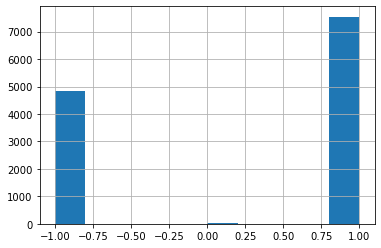

In [23]:
X_train['last_d_s'].hist()

In [24]:
X_train.columns.tolist()

['vol_trd',
 'n_trd',
 'vol_big',
 'n_big',
 'vol_big_ratio',
 'aggimb',
 'aggimb_big',
 'n_aggimb',
 'agg_net_m',
 'aggbig_net_m',
 'loc_agg_net_m',
 'loc_aggbig_net_m',
 'loc_agg_imb_m',
 'loc_aggbig_imb_m',
 'abagg',
 'n_p',
 'agg_net_d',
 'aggbig_net_d',
 'chgfreq',
 'last_d_s',
 'PA_up',
 'PA_down',
 'loc_agg_net_d',
 'loc_aggbig_net_d',
 'vewma',
 'rng_ewma',
 'vewma_g_p',
 'vewma_c_v',
 'vewmag_dif',
 'vol_trd_aux',
 'n_trd_aux',
 'vol_big_aux',
 'n_big_aux',
 'vol_big_ratio_aux',
 'aggimb_aux',
 'aggimb_big_aux',
 'n_aggimb_aux',
 'agg_net_m_aux',
 'aggbig_net_m_aux',
 'loc_agg_net_m_aux',
 'loc_aggbig_net_m_aux',
 'loc_agg_imb_m_aux',
 'loc_aggbig_imb_m_aux',
 'abagg_aux',
 'book_imb',
 'escora_bid_2.5_0.8',
 'escora_ask_2.5_0.8',
 'escora_bid_3.5_0.8',
 'escora_ask_3.5_0.8',
 'escora_bid_4.5_1.2',
 'escora_ask_4.5_1.2',
 'movesc_bid_2.5_0.9',
 'movesc_ask_2.5_0.9',
 'movesc_bid_3.5_0.5',
 'movesc_ask_3.5_0.5',
 'movesc_bid_4.5_0.9',
 'movesc_ask_4.5_0.9',
 'msg_imb',
 'smart_

array([[<AxesSubplot:title={'center':'aggbig_net_d'}>,
        <AxesSubplot:title={'center':'chgfreq'}>],
       [<AxesSubplot:title={'center':'last_d_s'}>,
        <AxesSubplot:title={'center':'PA_up'}>],
       [<AxesSubplot:title={'center':'PA_down'}>, <AxesSubplot:>]],
      dtype=object)

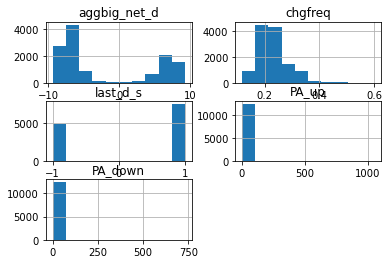

In [25]:
X_train[['aggbig_net_d',
 'chgfreq',
 'last_d_s',
 'PA_up',
 'PA_down',]].hist()

array([[<AxesSubplot:title={'center':'aggbig_net_d'}>]], dtype=object)

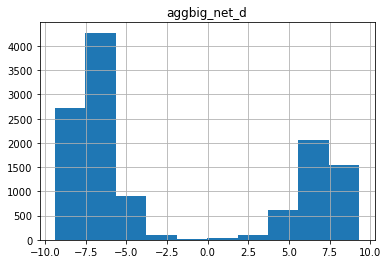

In [26]:
X_train[['aggbig_net_d']].hist()

array([[<AxesSubplot:title={'center':'chgfreq'}>]], dtype=object)

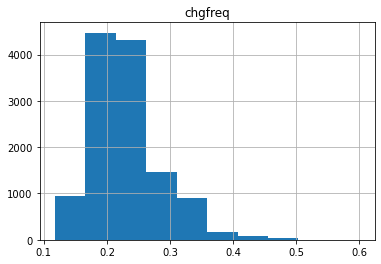

In [27]:
X_train[['chgfreq']].hist()

count   12389.000
mean        0.229
std         0.058
min         0.118
0.1%        0.118
1%          0.133
5%          0.154
10%         0.167
15%         0.167
20%         0.182
30%         0.200
40%         0.200
50%         0.222
60%         0.222
70%         0.250
80%         0.278
85%         0.286
90%         0.300
95%         0.333
99%         0.417
99.9%       0.500
max         0.600
Name: chgfreq, dtype: float64


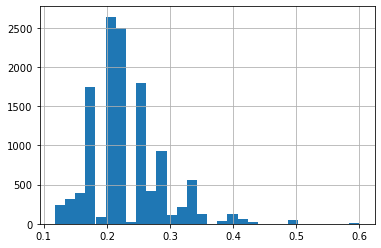

In [28]:
col = 'chgfreq'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


(0.11699999999999999, 0.167]    1877
(0.167, 0.182]                   810
(0.182, 0.2]                    2536
(0.2, 0.222]                    2553
(0.222, 0.25]                   1961
(0.25, 0.278]                    421
(0.278, 0.3]                    1034
(0.3, 0.6]                      1197
Name: chgfreq, dtype: int64


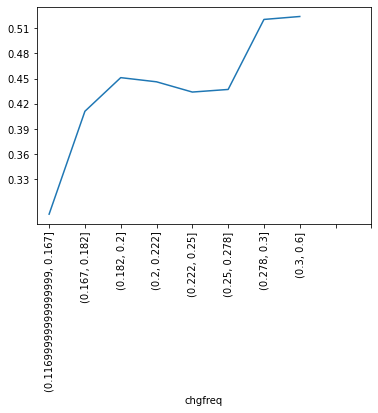

In [29]:
q=10
x_hist = pd.qcut(s_col, q=q, duplicates='drop')
xy = pd.concat([x_hist, y_train], axis=1)
mean_y = xy.groupby(col)['y'].mean()
mean_y.plot(yticks=(.33, .36, .39, .42, .45, .48, .51), xticks=range(q), rot=90)
print(x_hist.value_counts().sort_index())


<AxesSubplot:>

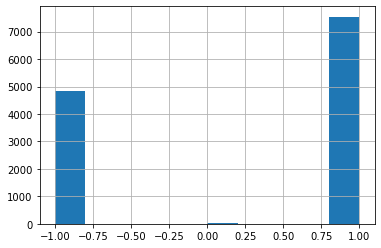

In [30]:
X_train['last_d_s'].hist()

In [31]:

# TODO: move function to ft_selection.py
def list_sub(lst1, lst2):
  final_list = list(set(lst1) - set(lst2))
  return final_list


def list_union(*l_lists):
  l_union = l_lists[0]
  if len(l_lists) > 1:
    for i in range(len(l_lists)-1):
      l_union = set(l_union) | set(l_lists[i+1])
  return list(l_union)

l_duplicate = ['loc_agg_net_m',]  # _2 ft comes from ft_eng.duplicate()

l_cap_1 = ['vewma_c_v', 'vewmag_dif', 'book_imb', 'book_imb_dif', ]

l_cap_5 = ['PA_up', 'PA_down', ]

l_cap_10 = ['n_big_aux', ]

l_cap_default = list_sub(X_train.columns.to_list(), list_union(l_cap_1, l_cap_5, l_cap_10))

l_bins_q2 = ['loc_agg_net_m_2',]  # _2 ft comes from ft_eng.duplicate()

l_bins_q4 = ['ohlc_10','ohlc_50',]

l_bins_q5 = ['loc_aggbig_net_m','vol_trd_aux','aggbig_net_m_aux','book_imb','rng_ewma_dif',
            'rng_ewma_dif_40','rng_ewma_dif_80','vewma_10','vewma_g_p_10','aggbig_net_10',
]

l_bins_q6 = ['agg_net_d', 'aggbig_net_d', 'loc_agg_imb_m_aux',]

l_bins_q8 = ['rng_ewma','vewma_g_p','vewmag_dif','n_trd_aux','abagg_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8',
            'escora_bid_3.5_0.8','escora_ask_3.5_0.8','escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_2.5_0.9',
            'movesc_ask_2.5_0.9','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','movesc_bid_4.5_0.9','movesc_ask_4.5_0.9',
            'msg_imb','rng_smart_10','imp_DIF_10','imp_DIF_50','agg_net_80','imp_FCAST_40','aggpior_DIF',
            'book_imb_mean_dif_cp','msg_imb_mean_10','escora_4.5_0.8_DIF',
]

l_bins_q10 = ['vol_big_ratio','aggimb','n_aggimb','agg_net_m','loc_aggbig_imb_m','abagg','n_p','vewma',
            'vewma_c_v', 'aggimb_aux','aggimb_big_aux','agg_net_m_aux','loc_aggbig_net_m_aux','smart_price_dif',
            'smart_price_50','rng_smart_50','agg_net_10','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10',
            'book_imb_mean_10','book_imb_mean_dif_lp','msg_imb_mean_40','msg_imb_mean_dif_lp','msg_imb_mean_dif_cp',
            'sspread_mean','movesc_2.5_0.7_DIF','msg_imb_mean_40_ABS','loc_agg_net_m',
] 

d_bins_arbitrary = {
            'n_trd':  [-0.01, 70, 180, 280, 380, 5000000],
            'vol_trd':  [0, 7.237, 7.55, 10000],
            'aggimb_big':		[-1.1, -0.4, 0.4, 1.1],
            'aggbig_net_m':		[-10000, -5, +10000],
            'chgfreq':		[-0.01, 0.167, 0.280, 1],
            'last_d_s':		[-1.01, -0.5, 0.5, 1.01],
            'loc_agg_net_d':		[-10000, -6.4, 5.2, 5.7, 10000],
            'loc_aggbig_net_d':		[-10000, -5.4, -3.8, 10000],
            'n_big_aux':	[-0.01, 3.1, 100],
            'vol_big_ratio_aux':		[-0.01, 0.275, 0.520, 1.01],
            'loc_agg_net_m_aux':		[-10000, -4.451, -3.592, -2.435, 3.607, 10000] ,
            'loc_aggbig_imb_m_aux':		[-1.1, -0.99, -0.391, -0.0118, 0.4, 0.99, 1.1],
            'aggpior_DIF_30':		[-7.625, -4.454, -4.111, -3.829, -3.26, -3.05, -3.04, -0.01, 0.01, 3.714, 7.6],
            'abs_DIF':		[-7.037, -4.796, -4.19, -0.1, 0.1, 2.398, 4.564, 7.19],
            'pagg_DIF':	[-1.1, -0.95, -0.6, -0.4, -0.001, 0.001, 0.4, 0.6, 0.95, 1.1],
            'book_imb_dif':	[-1000, -27, -14, -6.8, -2.5, 0.1, 4.29, 11.2, 22, 1000],
            'book_imb_mean_40': [-1000, -30, -20, -16, 1000],
            'aggpior_aux_DIF':		[-7.625, -4.331, -3.584, -3.045, -0.01, 0.01, 3.045, 7.6] ,
            'pagg_aux_DIF':		[-1.1, -0.95, -0.5, -0.001, 0.001, 0.5, 0.95, 1.1],
            'escora_3.5_1.2_DIF':		[-0.5, -0.171, -0.0482, 0, 0.0482, 0.0927, 0.5],
            'movesc_3.5_0.7_DIF':		[-17.5, -4.451, -1.391, -0.146, 0.0, 0.312, 8],
            'book_imb_mean_dif_cp_ABS':		[-0.01, 0.119, 500],
            'msg_imb_mean_dif_lp_ABS':		[-0.01, 0.281, 1.1],
            'loc_agg_imb_m':  [-1.01, -0.491, -0.366, -0.288, -0.223, -0.167, 1.01],
            'imp_FCAST_10': [-10000, -3.012, -1.674, -0.653, 10000],
}

l_bins_nulls = ['vol_big','n_big','PA_up','PA_down','vol_big_aux','n_aggimb_aux','imp_DIF','int_DIF',
                'int_DIF_50','abs_DIF_30','msg_imb_dif','depth_DIF',
                'depth_DIF_10','book_imb_mean_us_5','book_imb_mean_us_20','sspread_mean_us_5',
                'escora_2.5_2_DIF','movesc_4.5_0.7_DIF', 
                # TODO: 's_run', 'n_p_aux' treat for MW
]

# ft classification based on mean encoding 
l_ft_alta = ['pagg_DIF','loc_agg_net_m_aux','aggpior_aux_DIF','loc_agg_imb_m','vol_big_ratio','aggimb',
             'n_aggimb','agg_net_m','loc_aggbig_imb_m','n_p','vewma','agg_net_m_aux','smart_price_dif',
             'smart_price_50','agg_net_10','msg_imb_mean_40_ABS','ohlc_10','ohlc_50','loc_aggbig_net_m',
             'vol_trd_aux','aggbig_net_m_aux','rng_ewma_dif_80','vewma_10','rng_ewma','vewma_g_p','vewmag_dif',
             'n_trd_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8','escora_bid_3.5_0.8','escora_ask_3.5_0.8'
             ,'escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','msg_imb','rng_smart_10',
]

l_ft_media = ['last_d_s','aggimb_big','loc_aggbig_imb_m_aux','pagg_aux_DIF','movesc_3.5_0.7_DIF','abs_DIF',
              'book_imb_mean_dif_cp_ABS','book_imb_dif','abagg','vewma_c_v','aggimb_aux','loc_aggbig_net_m_aux',
              'rng_smart_50','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10','msg_imb_mean_dif_cp',
              'sspread_mean','movesc_2.5_0.7_DIF','loc_agg_net_m','book_imb','rng_ewma_dif','rng_ewma_dif_40',
              'vewma_g_p_10','aggbig_net_10','vol_trd','loc_agg_imb_m_aux','movesc_bid_2.5_0.9','movesc_ask_2.5_0.9',
              'movesc_bid_4.5_0.9','movesc_ask_4.5_0.9','imp_DIF_10','imp_FCAST_40','aggpior_DIF','book_imb_mean_dif_cp',
              'msg_imb_mean_10',
]


In [32]:
pipe_cap_outliers = Pipeline([
                ('cap1', Winsorizer(variables=l_cap_1, capping_method='quantiles', fold = 0.01, tail = 'both')),
                ('cap5', Winsorizer(variables=l_cap_5, capping_method='quantiles', fold = 0.05, tail = 'both')),
                ('cap10', Winsorizer(variables=l_cap_10, capping_method='quantiles', fold = 0.10, tail = 'both')),
                ('cap001', Winsorizer(variables=l_cap_default, capping_method='quantiles', fold = 0.001, tail = 'both')),
])

pipe_norm_scale = Pipeline([
                ('scaler', SklearnTransformerWrapper(transformer=RobustScaler({'quantile_range':(0.10, 0.90)}))),
                ('minmax', SklearnTransformerWrapper(transformer=MinMaxScaler())),
                # ('pca', PCA(n_components=30, svd_solver='auto')), 
                # ('isomap', Isomap(n_components=13, n_neighbors=50, n_jobs=-1)),   #  expensive
])

pipe_discrete = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=False, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=False, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=False, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=False, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=False, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=False, q=2, variables=l_bins_q2)),
])

pipe_mean_encoding = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=True, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=True, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=True, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=True, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=True, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=True, q=2, variables=l_bins_q2)),
                        ('mean_enc', MeanEncoder())
])

# X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)
# X_test_pre = pipe_cap_outliers.transform(X_test)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass with_centering={'quantile_range': (0.1, 0.9)} as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [33]:
pipe_cap_outliers = Pipeline([
                ('cap1', Winsorizer(variables=l_cap_1, capping_method='quantiles', fold = 0.01, tail = 'both')),
                ('cap5', Winsorizer(variables=l_cap_5, capping_method='quantiles', fold = 0.05, tail = 'both')),
                ('cap10', Winsorizer(variables=l_cap_10, capping_method='quantiles', fold = 0.10, tail = 'both')),
                ('cap001', Winsorizer(variables=l_cap_default, capping_method='quantiles', fold = 0.001, tail = 'both')),
])

pipe_norm_scale = Pipeline([
                ('scaler', SklearnTransformerWrapper(transformer=RobustScaler(quantile_range=(0.10, 0.90)))),
                ('minmax', SklearnTransformerWrapper(transformer=MinMaxScaler())),
                # ('pca', PCA(n_components=30, svd_solver='auto')), 
                # ('isomap', Isomap(n_components=13, n_neighbors=50, n_jobs=-1)),   #  expensive
])

pipe_discrete = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=False, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=False, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=False, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=False, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=False, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=False, q=2, variables=l_bins_q2)),
])

pipe_mean_encoding = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=True, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=True, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=True, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=True, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=True, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=True, q=2, variables=l_bins_q2)),
                        ('mean_enc', MeanEncoder())
])

# X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)
# X_test_pre = pipe_cap_outliers.transform(X_test)


In [34]:
X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)


In [35]:
X_train_transf

.426   
           961349 15:03:55.529000 22282      0.465         0.488       0.415   

                                          imp_DIF_50  agg_net_10  agg_net_40  \
date_trd   update time            trd_id                                       
2020-06-01 49460  09:21:41.989000 764          0.433       0.444       0.455   
           52825  09:23:20.039000 860          0.433       0.449       0.378   
           53165  09:23:31.093000 870          0.440       0.408       0.440   
           63011  09:29:48.428000 1137         0.433       0.493       0.457   
           67015  09:30:47.568000 1263         0.448       0.444       0.378   
...                                              ...         ...         ...   
2021-01-21 935156 14:51:18.956000 21691        0.448       0.243       0.440   
           936015 14:51:42.285000 21708        0.441       0.454       0.466   
           943637 14:55:13.748000 21898        0.433       0.408       0.314   
           948326 14:56:20.909000 22061        0.441       0.449       0.378   
           961349 15:03:55.529000 22282        0.448       0.458       0.378   

                                          agg_net_80  loc_agg_net_10  \
date_trd   update time            trd_id                               
2020-06-01 49460  09:21:41.989000 764          0.462           0.439   
           52825  09:23:20.039000 860          0.420           0.455   
           53165  09:23:31.093000 870          0.420           0.433   
           63011  09:29:48.428000 1137         0.480           0.439   
           67015  09:30:47.568000 1263         0.348           0.428   
...                                              ...             ...   
2021-01-21 935156 14:51:18.956000 21691        0.348           0.386   
           936015 14:51:42.285000 21708        0.423           0.386   
           943637 14:55:13.748000 21898        0.348           0.424   
           948326 14:56:20.909000 22061        0.348           0.452   
           961349 15:03:55.529000 22282        0.428           0.424   

                                          aggbig_net_10  int_DIF_10  \
date_trd   update time            trd_id                              
2020-06-01 49460  09:21:41.989000 764             0.459       0.451   
           52825  09:23:20.039000 860             0.459       0.451   
           53165  09:23:31.093000 870             0.368       0.422   
           63011  09:29:48.428000 1137            0.437       0.451   
           67015  09:30:47.568000 1263            0.459       0.451   
...                                                 ...         ...   
2021-01-21 935156 14:51:18.956000 21691           0.368       0.419   
           936015 14:51:42.285000 21708           0.464       0.451   
           943637 14:55:13.748000 21898           0.368       0.441   
           948326 14:56:20.909000 22061           0.368       0.383   
           961349 15:03:55.529000 22282           0.368       0.419   

                                          imp_FCAST_10  imp_FCAST_40  \
date_trd   update time            trd_id                               
2020-06-01 49460  09:21:41.989000 764                3         0.433   
           52825  09:23:20.039000 860                2         0.352   
           53165  09:23:31.093000 870                2         0.433   
           63011  09:29:48.428000 1137               2         0.465   
           67015  09:30:47.568000 1263               3         0.420   
...                                                ...           ...   
2021-01-21 935156 14:51:18.956000 21691              3         0.455   
           936015 14:51:42.285000 21708              3         0.455   
           943637 14:55:13.748000 21898              3         0.433   
           948326 14:56:20.909000 22061              2         0.420   
           961349 15:03:55.529000 22282              3         0.420   

                                          aggpior_DIF  aggpior_DIF_30  \

In [36]:
X_train_transf['loc_agg_net_m'].value_counts()

0.415    1239
0.397    1239
0.452    1239
0.436    1239
0.416    1239
0.391    1239
0.427    1239
0.465    1239
0.457    1239
0.469    1238
Name: loc_agg_net_m, dtype: int64

In [37]:
X_train_transf.loc[pd.isna(X_train_transf)].sum().sort_values(ascending=False)

ValueError: Cannot index with multidimensional key

In [38]:
pd.isna(X_train_transf)].sum()

SyntaxError: invalid syntax (<ipython-input-38-9a03873fb0a0>, line 1)

In [39]:
pd.isna(X_train_transf).sum()

vol_trd                     0
n_trd                       0
vol_big_ratio               0
aggimb                      0
aggimb_big                  0
                           ..
movesc_3.5_0.7_DIF          0
book_imb_mean_dif_cp_ABS    0
msg_imb_mean_40_ABS         0
msg_imb_mean_dif_lp_ABS     0
loc_agg_net_m_2             0
Length: 98, dtype: int64

In [40]:
pd.isna(X_train_transf).sum().sort_values(ascending=False)

n_big_aux            18
loc_agg_net_m_2       0
vewmag_dif            0
n_trd_aux             0
vol_big_ratio_aux     0
                     ..
agg_net_80            0
loc_agg_net_10        0
aggbig_net_10         0
int_DIF_10            0
vol_trd               0
Length: 98, dtype: int64

In [41]:
X_train_transf['n_big_aux'].value_counts()

0.000    8436
1.000    3935
Name: n_big_aux, dtype: int64

In [42]:
X_train['n_big_aux'].value_counts()

0      2757
1      2580
2      1855
3      1244
4       845
       ... 
154       1
98        1
74        1
50        1
111       1
Name: n_big_aux, Length: 102, dtype: int64

<AxesSubplot:>

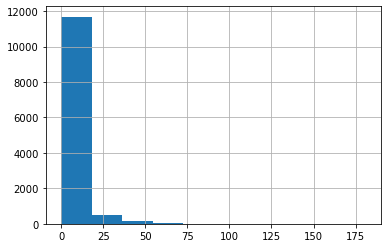

In [43]:
X_train['n_big_aux'].hist()

count   12389.000
mean        4.823
std         9.866
min         0.000
0.1%        0.000
1%          0.000
5%          0.000
10%         0.000
15%         0.000
20%         0.000
30%         1.000
40%         1.000
50%         2.000
60%         3.000
70%         4.000
80%         6.000
85%         8.000
90%        12.000
95%        20.000
99%        45.000
99.9%     108.612
max       181.000
Name: n_big_aux, dtype: float64


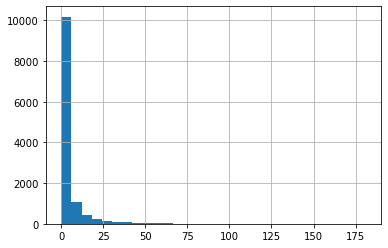

In [44]:
col = 'n_big_aux'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


(-0.001, 1.0]    5337
(1.0, 2.0]       1855
(2.0, 3.0]       1244
(3.0, 4.0]        845
(4.0, 6.0]        902
(6.0, 12.0]      1073
(12.0, 181.0]    1133
Name: n_big_aux, dtype: int64


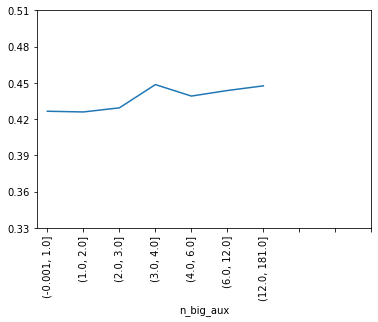

In [45]:
q=10
x_hist = pd.qcut(s_col, q=q, duplicates='drop')
xy = pd.concat([x_hist, y_train], axis=1)
mean_y = xy.groupby(col)['y'].mean()
mean_y.plot(yticks=(.33, .36, .39, .42, .45, .48, .51), xticks=range(q), rot=90)
print(x_hist.value_counts().sort_index())


In [46]:

# TODO: move function to ft_selection.py
def list_sub(lst1, lst2):
  final_list = list(set(lst1) - set(lst2))
  return final_list


def list_union(*l_lists):
  l_union = l_lists[0]
  if len(l_lists) > 1:
    for i in range(len(l_lists)-1):
      l_union = set(l_union) | set(l_lists[i+1])
  return list(l_union)

l_duplicate = ['loc_agg_net_m',]  # _2 ft comes from ft_eng.duplicate()

l_cap_1 = ['vewma_c_v', 'vewmag_dif', 'book_imb', 'book_imb_dif', ]

l_cap_5 = ['PA_up', 'PA_down', ]

l_cap_10 = ['n_big_aux', ]

l_cap_default = list_sub(X_train.columns.to_list(), list_union(l_cap_1, l_cap_5, l_cap_10))

l_bins_q2 = ['loc_agg_net_m_2',]  # _2 ft comes from ft_eng.duplicate()

l_bins_q4 = ['ohlc_10','ohlc_50',]

l_bins_q5 = ['loc_aggbig_net_m','vol_trd_aux','aggbig_net_m_aux','book_imb','rng_ewma_dif',
            'rng_ewma_dif_40','rng_ewma_dif_80','vewma_10','vewma_g_p_10','aggbig_net_10',
]

l_bins_q6 = ['agg_net_d', 'aggbig_net_d', 'loc_agg_imb_m_aux',]

l_bins_q8 = ['rng_ewma','vewma_g_p','vewmag_dif','n_trd_aux','abagg_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8',
            'escora_bid_3.5_0.8','escora_ask_3.5_0.8','escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_2.5_0.9',
            'movesc_ask_2.5_0.9','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','movesc_bid_4.5_0.9','movesc_ask_4.5_0.9',
            'msg_imb','rng_smart_10','imp_DIF_10','imp_DIF_50','agg_net_80','imp_FCAST_40','aggpior_DIF',
            'book_imb_mean_dif_cp','msg_imb_mean_10','escora_4.5_0.8_DIF',
]

l_bins_q10 = ['vol_big_ratio','aggimb','n_aggimb','agg_net_m','loc_aggbig_imb_m','abagg','n_p','vewma',
            'vewma_c_v', 'aggimb_aux','aggimb_big_aux','agg_net_m_aux','loc_aggbig_net_m_aux','smart_price_dif',
            'smart_price_50','rng_smart_50','agg_net_10','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10',
            'book_imb_mean_10','book_imb_mean_dif_lp','msg_imb_mean_40','msg_imb_mean_dif_lp','msg_imb_mean_dif_cp',
            'sspread_mean','movesc_2.5_0.7_DIF','msg_imb_mean_40_ABS','loc_agg_net_m',
] 

d_bins_arbitrary = {
            'n_trd':  [-0.01, 70, 180, 280, 380, 5000000],
            'vol_trd':  [0, 7.237, 7.55, 10000],
            'aggimb_big':		[-1.1, -0.4, 0.4, 1.1],
            'aggbig_net_m':		[-10000, -5, +10000],
            'chgfreq':		[-0.01, 0.167, 0.280, 1],
            'last_d_s':		[-1.01, -0.5, 0.5, 1.01],
            'loc_agg_net_d':		[-10000, -6.4, 5.2, 5.7, 10000],
            'loc_aggbig_net_d':		[-10000, -5.4, -3.8, 10000],
            'n_big_aux':	[-0.01, 3.1, 1000],
            'vol_big_ratio_aux':		[-0.01, 0.275, 0.520, 1.01],
            'loc_agg_net_m_aux':		[-10000, -4.451, -3.592, -2.435, 3.607, 10000] ,
            'loc_aggbig_imb_m_aux':		[-1.1, -0.99, -0.391, -0.0118, 0.4, 0.99, 1.1],
            'aggpior_DIF_30':		[-7.625, -4.454, -4.111, -3.829, -3.26, -3.05, -3.04, -0.01, 0.01, 3.714, 7.6],
            'abs_DIF':		[-7.037, -4.796, -4.19, -0.1, 0.1, 2.398, 4.564, 7.19],
            'pagg_DIF':	[-1.1, -0.95, -0.6, -0.4, -0.001, 0.001, 0.4, 0.6, 0.95, 1.1],
            'book_imb_dif':	[-1000, -27, -14, -6.8, -2.5, 0.1, 4.29, 11.2, 22, 1000],
            'book_imb_mean_40': [-1000, -30, -20, -16, 1000],
            'aggpior_aux_DIF':		[-7.625, -4.331, -3.584, -3.045, -0.01, 0.01, 3.045, 7.6] ,
            'pagg_aux_DIF':		[-1.1, -0.95, -0.5, -0.001, 0.001, 0.5, 0.95, 1.1],
            'escora_3.5_1.2_DIF':		[-0.5, -0.171, -0.0482, 0, 0.0482, 0.0927, 0.5],
            'movesc_3.5_0.7_DIF':		[-17.5, -4.451, -1.391, -0.146, 0.0, 0.312, 8],
            'book_imb_mean_dif_cp_ABS':		[-0.01, 0.119, 500],
            'msg_imb_mean_dif_lp_ABS':		[-0.01, 0.281, 1.1],
            'loc_agg_imb_m':  [-1.01, -0.491, -0.366, -0.288, -0.223, -0.167, 1.01],
            'imp_FCAST_10': [-10000, -3.012, -1.674, -0.653, 10000],
}

l_bins_nulls = ['vol_big','n_big','PA_up','PA_down','vol_big_aux','n_aggimb_aux','imp_DIF','int_DIF',
                'int_DIF_50','abs_DIF_30','msg_imb_dif','depth_DIF',
                'depth_DIF_10','book_imb_mean_us_5','book_imb_mean_us_20','sspread_mean_us_5',
                'escora_2.5_2_DIF','movesc_4.5_0.7_DIF', 
                # TODO: 's_run', 'n_p_aux' treat for MW
]

# ft classification based on mean encoding 
l_ft_alta = ['pagg_DIF','loc_agg_net_m_aux','aggpior_aux_DIF','loc_agg_imb_m','vol_big_ratio','aggimb',
             'n_aggimb','agg_net_m','loc_aggbig_imb_m','n_p','vewma','agg_net_m_aux','smart_price_dif',
             'smart_price_50','agg_net_10','msg_imb_mean_40_ABS','ohlc_10','ohlc_50','loc_aggbig_net_m',
             'vol_trd_aux','aggbig_net_m_aux','rng_ewma_dif_80','vewma_10','rng_ewma','vewma_g_p','vewmag_dif',
             'n_trd_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8','escora_bid_3.5_0.8','escora_ask_3.5_0.8'
             ,'escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','msg_imb','rng_smart_10',
]

l_ft_media = ['last_d_s','aggimb_big','loc_aggbig_imb_m_aux','pagg_aux_DIF','movesc_3.5_0.7_DIF','abs_DIF',
              'book_imb_mean_dif_cp_ABS','book_imb_dif','abagg','vewma_c_v','aggimb_aux','loc_aggbig_net_m_aux',
              'rng_smart_50','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10','msg_imb_mean_dif_cp',
              'sspread_mean','movesc_2.5_0.7_DIF','loc_agg_net_m','book_imb','rng_ewma_dif','rng_ewma_dif_40',
              'vewma_g_p_10','aggbig_net_10','vol_trd','loc_agg_imb_m_aux','movesc_bid_2.5_0.9','movesc_ask_2.5_0.9',
              'movesc_bid_4.5_0.9','movesc_ask_4.5_0.9','imp_DIF_10','imp_FCAST_40','aggpior_DIF','book_imb_mean_dif_cp',
              'msg_imb_mean_10',
]


In [47]:
pipe_cap_outliers = Pipeline([
                ('cap1', Winsorizer(variables=l_cap_1, capping_method='quantiles', fold = 0.01, tail = 'both')),
                ('cap5', Winsorizer(variables=l_cap_5, capping_method='quantiles', fold = 0.05, tail = 'both')),
                ('cap10', Winsorizer(variables=l_cap_10, capping_method='quantiles', fold = 0.10, tail = 'both')),
                ('cap001', Winsorizer(variables=l_cap_default, capping_method='quantiles', fold = 0.001, tail = 'both')),
])

pipe_norm_scale = Pipeline([
                ('scaler', SklearnTransformerWrapper(transformer=RobustScaler(quantile_range=(0.10, 0.90)))),
                ('minmax', SklearnTransformerWrapper(transformer=MinMaxScaler())),
                # ('pca', PCA(n_components=30, svd_solver='auto')), 
                # ('isomap', Isomap(n_components=13, n_neighbors=50, n_jobs=-1)),   #  expensive
])

pipe_discrete = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=False, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=False, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=False, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=False, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=False, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=False, q=2, variables=l_bins_q2)),
])

pipe_mean_encoding = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=True, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=True, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=True, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=True, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=True, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=True, q=2, variables=l_bins_q2)),
                        ('mean_enc', MeanEncoder())
])

# X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)
# X_test_pre = pipe_cap_outliers.transform(X_test)


count   12389.000
mean       -1.590
std         3.105
min        -7.624
0.1%       -5.864
1%         -5.252
5%         -4.754
10%        -4.454
15%        -4.263
20%        -4.111
30%        -3.829
40%        -3.434
50%        -3.045
60%        -2.398
70%         0.000
80%         0.000
85%         3.045
90%         3.714
95%         4.710
99%         5.602
99.9%       6.219
max         7.009
Name: aggpior_DIF_30, dtype: float64


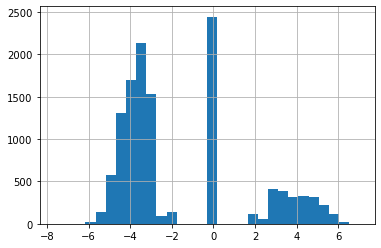

In [48]:
col = 'aggpior_DIF_30'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


count   12389.000
mean       -0.637
std        40.592
min     -1035.273
0.1%     -279.018
1%        -85.623
5%        -38.563
10%       -26.060
15%       -20.549
20%       -16.886
30%       -11.543
40%        -7.061
50%        -3.063
60%         1.247
70%         5.933
80%        12.306
85%        16.972
90%        24.641
95%        42.335
99%       133.765
99.9%     358.433
max       810.754
Name: book_imb_mean_40, dtype: float64


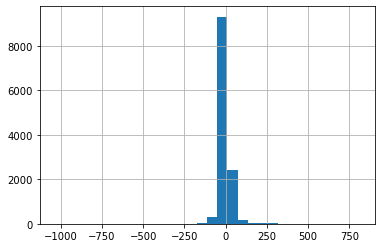

In [49]:
col = 'book_imb_mean_40'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


count   12389.000
mean       -0.002
std         0.108
min        -0.393
0.1%       -0.393
1%         -0.393
5%         -0.171
10%        -0.103
15%        -0.073
20%        -0.048
30%        -0.021
40%         0.000
50%         0.000
60%         0.000
70%         0.021
80%         0.048
85%         0.062
90%         0.093
95%         0.151
99%         0.393
99.9%       0.393
max         0.393
Name: escora_3.5_1.2_DIF, dtype: float64


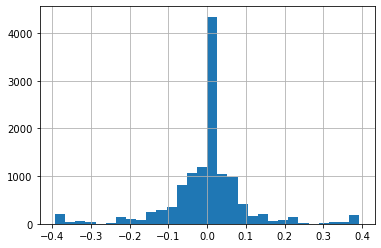

In [50]:
col = 'escora_3.5_1.2_DIF'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


count   12389.000
mean       -0.318
std         1.505
min       -17.499
0.1%       -7.122
1%         -6.000
5%         -4.451
10%        -1.391
15%        -0.433
20%        -0.146
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
85%         0.087
90%         0.312
95%         0.875
99%         3.000
99.9%       5.586
max         7.875
Name: movesc_3.5_0.7_DIF, dtype: float64


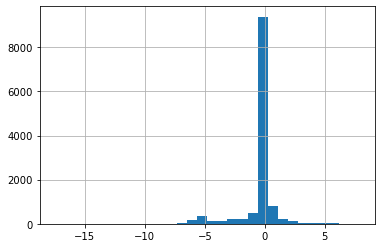

In [51]:
col = 'movesc_3.5_0.7_DIF'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


count   12389.000
mean       13.444
std        20.250
min         0.000
0.1%        0.000
1%          0.000
5%          0.119
10%         0.909
15%         1.795
20%         2.574
30%         4.318
40%         6.230
50%         8.609
60%        11.254
70%        14.504
80%        19.286
85%        22.549
90%        27.998
95%        39.800
99%        91.174
99.9%     228.536
max       497.354
Name: book_imb_mean_dif_cp_ABS, dtype: float64


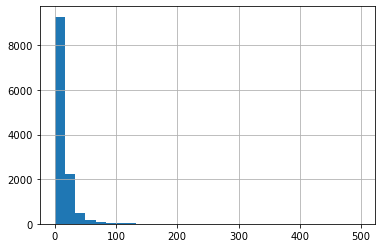

In [52]:
col = 'book_imb_mean_dif_cp_ABS'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


count   12389.000
mean        0.109
std         0.089
min         0.000
0.1%        0.000
1%          0.001
5%          0.008
10%         0.016
15%         0.024
20%         0.032
30%         0.051
40%         0.069
50%         0.089
60%         0.112
70%         0.139
80%         0.175
85%         0.198
90%         0.228
95%         0.281
99%         0.395
99.9%       0.552
max         0.713
Name: msg_imb_mean_dif_lp_ABS, dtype: float64


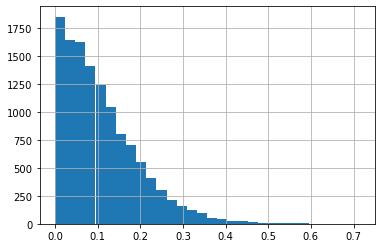

In [53]:
col = 'msg_imb_mean_dif_lp_ABS'
s_col = X_train[col]
# s_col = X_train[col].abs()
# col = col + '_ABS'
# s_col.rename(col, inplace=True)

s_col.hist(bins=30)
print(s_col.describe(percentiles=[.001, .01, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, .999]))


In [54]:

# TODO: move function to ft_selection.py
def list_sub(lst1, lst2):
  final_list = list(set(lst1) - set(lst2))
  return final_list


def list_union(*l_lists):
  l_union = l_lists[0]
  if len(l_lists) > 1:
    for i in range(len(l_lists)-1):
      l_union = set(l_union) | set(l_lists[i+1])
  return list(l_union)

l_duplicate = ['loc_agg_net_m',]  # _2 ft comes from ft_eng.duplicate()

l_cap_1 = ['vewma_c_v', 'vewmag_dif', 'book_imb', 'book_imb_dif', ]

l_cap_5 = ['PA_up', 'PA_down', ]

l_cap_10 = ['n_big_aux', ]

l_cap_default = list_sub(X_train.columns.to_list(), list_union(l_cap_1, l_cap_5, l_cap_10))

l_bins_q2 = ['loc_agg_net_m_2',]  # _2 ft comes from ft_eng.duplicate()

l_bins_q4 = ['ohlc_10','ohlc_50',]

l_bins_q5 = ['loc_aggbig_net_m','vol_trd_aux','aggbig_net_m_aux','book_imb','rng_ewma_dif',
            'rng_ewma_dif_40','rng_ewma_dif_80','vewma_10','vewma_g_p_10','aggbig_net_10',
]

l_bins_q6 = ['agg_net_d', 'aggbig_net_d', 'loc_agg_imb_m_aux',]

l_bins_q8 = ['rng_ewma','vewma_g_p','vewmag_dif','n_trd_aux','abagg_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8',
            'escora_bid_3.5_0.8','escora_ask_3.5_0.8','escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_2.5_0.9',
            'movesc_ask_2.5_0.9','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','movesc_bid_4.5_0.9','movesc_ask_4.5_0.9',
            'msg_imb','rng_smart_10','imp_DIF_10','imp_DIF_50','agg_net_80','imp_FCAST_40','aggpior_DIF',
            'book_imb_mean_dif_cp','msg_imb_mean_10','escora_4.5_0.8_DIF',
]

l_bins_q10 = ['vol_big_ratio','aggimb','n_aggimb','agg_net_m','loc_aggbig_imb_m','abagg','n_p','vewma',
            'vewma_c_v', 'aggimb_aux','aggimb_big_aux','agg_net_m_aux','loc_aggbig_net_m_aux','smart_price_dif',
            'smart_price_50','rng_smart_50','agg_net_10','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10',
            'book_imb_mean_10','book_imb_mean_dif_lp','msg_imb_mean_40','msg_imb_mean_dif_lp','msg_imb_mean_dif_cp',
            'sspread_mean','movesc_2.5_0.7_DIF','msg_imb_mean_40_ABS','loc_agg_net_m',
] 

d_bins_arbitrary = {
            'n_trd':  [-0.01, 70, 180, 280, 380, 5000000],
            'vol_trd':  [0, 7.237, 7.55, 10000],
            'aggimb_big':		[-1.1, -0.4, 0.4, 1.1],
            'aggbig_net_m':		[-10000, -5, +10000],
            'chgfreq':		[-0.01, 0.167, 0.280, 1.01],
            'last_d_s':		[-1.01, -0.5, 0.5, 1.01],
            'loc_agg_net_d':		[-10000, -6.4, 5.2, 5.7, 10000],
            'loc_aggbig_net_d':		[-10000, -5.4, -3.8, 10000],
            'n_big_aux':	[-0.01, 3.1, 1000],
            'vol_big_ratio_aux':		[-0.01, 0.275, 0.520, 1.01],
            'loc_agg_net_m_aux':		[-10000, -4.451, -3.592, -2.435, 3.607, 10000] ,
            'loc_aggbig_imb_m_aux':		[-1.1, -0.99, -0.391, -0.0118, 0.4, 0.99, 1.1],
            'aggpior_DIF_30':		[-10000, -4.454, -4.111, -3.829, -3.26, -3.05, -3.04, -0.01, 0.01, 3.714, 10000],
            'abs_DIF':		[-10000, -4.796, -4.19, -0.1, 0.1, 2.398, 4.564, 10000],
            'pagg_DIF':	[-1.1, -0.95, -0.6, -0.4, -0.001, 0.001, 0.4, 0.6, 0.95, 1.1],
            'book_imb_dif':	[-1000, -27, -14, -6.8, -2.5, 0.1, 4.29, 11.2, 22, 1000],
            'book_imb_mean_40': [-10000, -30, -20, -16, 10000],
            'aggpior_aux_DIF':		[-10000, -4.331, -3.584, -3.045, -0.01, 0.01, 3.045, 10000] ,
            'pagg_aux_DIF':		[-1.1, -0.95, -0.5, -0.001, 0.001, 0.5, 0.95, 1.1],
            'escora_3.5_1.2_DIF':		[-1.1, -0.171, -0.0482, 0, 0.0482, 0.0927, 1.1],
            'movesc_3.5_0.7_DIF':		[-10000, -4.451, -1.391, -0.146, 0.0, 0.312, 10000],
            'book_imb_mean_dif_cp_ABS':		[-0.01, 0.119, 10000],
            'msg_imb_mean_dif_lp_ABS':		[-0.01, 0.281, 1.1],
            'loc_agg_imb_m':  [-1.01, -0.491, -0.366, -0.288, -0.223, -0.167, 1.01],
            'imp_FCAST_10': [-10000, -3.012, -1.674, -0.653, 10000],
}

l_bins_nulls = ['vol_big','n_big','PA_up','PA_down','vol_big_aux','n_aggimb_aux','imp_DIF','int_DIF',
                'int_DIF_50','abs_DIF_30','msg_imb_dif','depth_DIF',
                'depth_DIF_10','book_imb_mean_us_5','book_imb_mean_us_20','sspread_mean_us_5',
                'escora_2.5_2_DIF','movesc_4.5_0.7_DIF', 
                # TODO: 's_run', 'n_p_aux' treat for MW
]

# ft classification based on mean encoding 
l_ft_alta = ['pagg_DIF','loc_agg_net_m_aux','aggpior_aux_DIF','loc_agg_imb_m','vol_big_ratio','aggimb',
             'n_aggimb','agg_net_m','loc_aggbig_imb_m','n_p','vewma','agg_net_m_aux','smart_price_dif',
             'smart_price_50','agg_net_10','msg_imb_mean_40_ABS','ohlc_10','ohlc_50','loc_aggbig_net_m',
             'vol_trd_aux','aggbig_net_m_aux','rng_ewma_dif_80','vewma_10','rng_ewma','vewma_g_p','vewmag_dif',
             'n_trd_aux','escora_bid_2.5_0.8','escora_ask_2.5_0.8','escora_bid_3.5_0.8','escora_ask_3.5_0.8'
             ,'escora_bid_4.5_1.2','escora_ask_4.5_1.2','movesc_bid_3.5_0.5','movesc_ask_3.5_0.5','msg_imb','rng_smart_10',
]

l_ft_media = ['last_d_s','aggimb_big','loc_aggbig_imb_m_aux','pagg_aux_DIF','movesc_3.5_0.7_DIF','abs_DIF',
              'book_imb_mean_dif_cp_ABS','book_imb_dif','abagg','vewma_c_v','aggimb_aux','loc_aggbig_net_m_aux',
              'rng_smart_50','agg_net_40','loc_agg_net_10','int_DIF_10','abagg_10','msg_imb_mean_dif_cp',
              'sspread_mean','movesc_2.5_0.7_DIF','loc_agg_net_m','book_imb','rng_ewma_dif','rng_ewma_dif_40',
              'vewma_g_p_10','aggbig_net_10','vol_trd','loc_agg_imb_m_aux','movesc_bid_2.5_0.9','movesc_ask_2.5_0.9',
              'movesc_bid_4.5_0.9','movesc_ask_4.5_0.9','imp_DIF_10','imp_FCAST_40','aggpior_DIF','book_imb_mean_dif_cp',
              'msg_imb_mean_10',
]


In [55]:
pipe_cap_outliers = Pipeline([
                ('cap1', Winsorizer(variables=l_cap_1, capping_method='quantiles', fold = 0.01, tail = 'both')),
                ('cap5', Winsorizer(variables=l_cap_5, capping_method='quantiles', fold = 0.05, tail = 'both')),
                ('cap10', Winsorizer(variables=l_cap_10, capping_method='quantiles', fold = 0.10, tail = 'both')),
                ('cap001', Winsorizer(variables=l_cap_default, capping_method='quantiles', fold = 0.001, tail = 'both')),
])

pipe_norm_scale = Pipeline([
                ('scaler', SklearnTransformerWrapper(transformer=RobustScaler(quantile_range=(0.10, 0.90)))),
                ('minmax', SklearnTransformerWrapper(transformer=MinMaxScaler())),
                # ('pca', PCA(n_components=30, svd_solver='auto')), 
                # ('isomap', Isomap(n_components=13, n_neighbors=50, n_jobs=-1)),   #  expensive
])

pipe_discrete = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=False, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=False, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=False, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=False, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=False, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=False, q=2, variables=l_bins_q2)),
])

pipe_mean_encoding = Pipeline([('drop', DropFeatures(l_bins_nulls)),
                        ('duplicate', ft_eng.Duplicate(l_duplicate)),
                        ('outliers_all', Winsorizer(capping_method='quantiles', fold = 0.001, tail = 'both')),
                        ('bins_manual', ArbitraryDiscretiser(d_bins_arbitrary)),
                        ('bins_q10', EqualFrequencyDiscretiser(return_object=True, q=10, variables=l_bins_q10)),
                        ('bins_q8', EqualFrequencyDiscretiser(return_object=True, q=8, variables=l_bins_q8)),
                        ('bins_q6', EqualFrequencyDiscretiser(return_object=True, q=6, variables=l_bins_q6)),
                        ('bins_q5', EqualFrequencyDiscretiser(return_object=True, q=5, variables=l_bins_q5)),
                        ('bins_q4', EqualFrequencyDiscretiser(return_object=True, q=4, variables=l_bins_q4)),
                        ('bins_q2', EqualFrequencyDiscretiser(return_object=True, q=2, variables=l_bins_q2)),
                        ('mean_enc', MeanEncoder())
])

# X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)
# X_test_pre = pipe_cap_outliers.transform(X_test)


In [56]:
X_train_transf = pipe_mean_encoding.fit_transform(X_train, y_train)


In [57]:
pd.isna(X_train_transf).sum().sort_values(ascending=False)

loc_agg_net_m_2      0
vewmag_dif           0
n_trd_aux            0
n_big_aux            0
vol_big_ratio_aux    0
                    ..
agg_net_80           0
loc_agg_net_10       0
aggbig_net_10        0
int_DIF_10           0
vol_trd              0
Length: 98, dtype: int64

In [58]:
list_union(l_ft_alta, l_ft_media)

['ohlc_50',
 'sspread_mean',
 'rng_ewma_dif',
 'vewma',
 'vewmag_dif',
 'loc_aggbig_net_m',
 'msg_imb',
 'vewma_c_v',
 'movesc_bid_2.5_0.9',
 'rng_smart_10',
 'imp_FCAST_40',
 'loc_aggbig_net_m_aux',
 'book_imb_mean_dif_cp',
 'aggimb_big',
 'ohlc_10',
 'escora_bid_2.5_0.8',
 'movesc_3.5_0.7_DIF',
 'agg_net_m_aux',
 'abs_DIF',
 'movesc_bid_4.5_0.9',
 'vewma_g_p',
 'loc_agg_net_m_aux',
 'loc_agg_imb_m',
 'rng_smart_50',
 'rng_ewma',
 'aggpior_DIF',
 'agg_net_10',
 'n_p',
 'movesc_bid_3.5_0.5',
 'movesc_2.5_0.7_DIF',
 'imp_DIF_10',
 'last_d_s',
 'msg_imb_mean_dif_cp',
 'movesc_ask_3.5_0.5',
 'aggimb_aux',
 'smart_price_dif',
 'book_imb_dif',
 'movesc_ask_4.5_0.9',
 'vol_trd_aux',
 'aggimb',
 'n_aggimb',
 'vol_trd',
 'escora_bid_3.5_0.8',
 'movesc_ask_2.5_0.9',
 'aggbig_net_m_aux',
 'book_imb',
 'smart_price_50',
 'pagg_DIF',
 'escora_bid_4.5_1.2',
 'agg_net_40',
 'msg_imb_mean_10',
 'loc_aggbig_imb_m',
 'int_DIF_10',
 'loc_aggbig_imb_m_aux',
 'vewma_10',
 'vewma_g_p_10',
 'agg_net_m',
 'a

In [59]:
len(list_union(l_ft_alta, l_ft_media))

74

In [60]:
pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])

pipe_svm_mean_encoding.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_mean_encoding, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
train_auc: 0.62, test_auc: 0.54 (overfit: 0.08)
train_f1:  0.60, test_f1:  0.53 (overfit: 0.07)
train_f*:  0.53, test_f*:  0.47 (overfit: 0.06)
--------
cm_train: 
[[2787 4244]
 [1211 4147]]
cm_test: 
[[ 696 1084]
 [ 452  866]]
threshold: 0.4


In [61]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance')),
                    # ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=SVC(class_weight = 'balanced', cache_size=5000))),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)


NameError: name 'SmartCorrelatedSelection' is not defined

In [62]:
from feature_engine.selection import SmartCorrelatedSelection


In [63]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance')),
                    # ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=SVC(class_weight = 'balanced', cache_size=5000))),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)


In [64]:
X_selection

.061        0.240   
           961349 15:03:55.529000 22282          0.323     0.308        0.569   

                                          agg_net_10   n_p  \
date_trd   update time            trd_id                     
2020-06-01 49460  09:21:41.989000 764          0.506 0.000   
           52825  09:23:20.039000 860          0.220 0.082   
           53165  09:23:31.093000 870          0.152 0.115   
           63011  09:29:48.428000 1137         0.793 0.098   
           67015  09:30:47.568000 1263         0.349 0.082   
...                                              ...   ...   
2021-01-21 935156 14:51:18.956000 21691        0.110 0.098   
           936015 14:51:42.285000 21708        0.903 0.131   
           943637 14:55:13.748000 21898        0.138 0.082   
           948326 14:56:20.909000 22061        0.220 0.115   
           961349 15:03:55.529000 22282        0.774 0.098   

                                          movesc_2.5_0.7_DIF  imp_DIF_10  \
date_trd   update time            trd_id                                   
2020-06-01 49460  09:21:41.989000 764                  0.543       0.472   
           52825  09:23:20.039000 860                  0.487       0.472   
           53165  09:23:31.093000 870                  0.596       0.370   
           63011  09:29:48.428000 1137                 0.785       0.260   
           67015  09:30:47.568000 1263                 0.543       0.472   
...                                                      ...         ...   
2021-01-21 935156 14:51:18.956000 21691                0.641       0.452   
           936015 14:51:42.285000 21708                0.699       0.471   
           943637 14:55:13.748000 21898                0.579       0.423   
           948326 14:56:20.909000 22061                0.558       0.506   
           961349 15:03:55.529000 22282                0.579       0.444   

                                          last_d_s  msg_imb_mean_dif_cp  \
date_trd   update time            trd_id                                  
2020-06-01 49460  09:21:41.989000 764        1.000                0.709   
           52825  09:23:20.039000 860        0.000                0.319   
           53165  09:23:31.093000 870        0.000                0.457   
           63011  09:29:48.428000 1137       1.000                0.440   
           67015  09:30:47.568000 1263       0.000                0.619   
...                                            ...                  ...   
2021-01-21 935156 14:51:18.956000 21691      1.000                0.536   
           936015 14:51:42.285000 21708      1.000                0.477   
           943637 14:55:13.748000 21898      0.000                0.539   
           948326 14:56:20.909000 22061      0.000                0.282   
           961349 15:03:55.529000 22282      1.000                0.717   

                                          movesc_ask_3.5_0.5  aggimb_aux  \
date_trd   update time            trd_id                                   
2020-06-01 49460  09:21:41.989000 764                  0.349       0.569   
           52825  09:23:20.039000 860                  0.367       0.406   
           53165  09:23:31.093000 870                  0.350       0.406   
           63011  09:29:48.428000 1137                 0.313       0.515   
           67015  09:30:47.568000 1263                 0.350       0.200   
...                                                      ...         ...   
2021-01-21 935156 14:51:18.956000 21691                0.326       0.426   
           936015 14:51:42.285000 21708                0.329       0.552   
           943637 14:55:13.748000 21898                0.351       0.339   
           948326 14:56:20.909000 22061                0.331       0.391   
           961349 15:03:55.529000 22282                0.361       0.446   

                                          book_imb_dif  movesc_ask_4.5_0.9  \
date_trd   update time            trd_id                  

In [65]:
X_train

0  \
date_trd   update time            trd_id                                
2020-06-01 49460  09:21:41.989000 764          -4.263           0.000   
           52825  09:23:20.039000 860          -3.714          -3.045   
           53165  09:23:31.093000 870          -4.111          -3.714   
           63011  09:29:48.428000 1137          0.000           0.000   
           67015  09:30:47.568000 1263         -4.454          -4.454   
...                                               ...             ...   
2021-01-21 935156 14:51:18.956000 21691         0.000           3.045   
           936015 14:51:42.285000 21708         0.000           3.045   
           943637 14:55:13.748000 21898         4.331           5.916   
           948326 14:56:20.909000 22061        -3.714           4.394   
           961349 15:03:55.529000 22282         0.000           0.000   

                                          abs_DIF  abs_DIF_30  pagg_DIF  \
date_trd   update time            trd_id                                  
2020-06-01 49460  09:21:41.989000 764       0.000      -4.984    -1.000   
           52825  09:23:20.039000 860       0.000       0.000     0.000   
           53165  09:23:31.093000 870       0.000       0.000     0.000   
           63011  09:29:48.428000 1137      0.000       0.000     0.000   
           67015  09:30:47.568000 1263      0.000       0.000    -1.000   
...                                           ...         ...       ...   
2021-01-21 935156 14:51:18.956000 21691     5.112       5.226    -0.343   
           936015 14:51:42.285000 21708     3.434       1.792     1.000   
           943637 14:55:13.748000 21898    -4.984      -4.984     1.000   
           948326 14:56:20.909000 22061    -5.832      -5.690     0.832   
           961349 15:03:55.529000 22282    -3.932      -3.932     0.000   

                                          abagg_10  book_imb_dif  \
date_trd   update time            trd_id                           
2020-06-01 49460  09:21:41.989000 764       -3.045       -61.401   
           52825  09:23:20.039000 860       -3.714       -27.633   
           53165  09:23:31.093000 870       -2.398        21.781   
           63011  09:29:48.428000 1137      -4.263        15.288   
           67015  09:30:47.568000 1263      -3.434         1.621   
...                                            ...           ...   
2021-01-21 935156 14:51:18.956000 21691     -2.398       -45.889   
           936015 14:51:42.285000 21708     -3.258       -18.742   
           943637 14:55:13.748000 21898     -3.258        10.026   
           948326 14:56:20.909000 22061      3.258       -10.933   
           961349 15:03:55.529000 22282     -3.932        -1.296   

                                          book_imb_mean_10  book_imb_mean_40  \
date_trd   update time            trd_id                                       
2020-06-01 49460  09:21:41.989000 764              -18.922           -20.056   
           52825  09:23:20.039000 860              -17.584           -13.702   
           53165  09:23:31.093000 870              -21.022           -14.731   
           63011  09:29:48.428000 1137              15.062            -3.231   
           67015  09:30:47.568000 1263             -13.110           -15.334   
...                                                    ...               ...   
2021-01-21 935156 14:51:18.956000 21691            -18.432           -17.280   
           936015 14:51:42.285000 21708             -5.643            -7.405   
           943637 14:55:13.748000 21898             -0.088             2.154   
           948326 14:56:20.909000 22061             16.306             5.557   
           961349 15:03:55.529000 22282             37.175            29.523   

                                          book_imb_mean_dif_lp  \
date_trd   update time            trd_id                         
2020-06-01 49460  09:21:41.989000 764                    1.134   
           52825  

In [66]:
from feature_engine.selection import RecursiveFeatureAddition


In [67]:
X_train.columns.tolist()

['vol_trd',
 'n_trd',
 'vol_big',
 'n_big',
 'vol_big_ratio',
 'aggimb',
 'aggimb_big',
 'n_aggimb',
 'agg_net_m',
 'aggbig_net_m',
 'loc_agg_net_m',
 'loc_aggbig_net_m',
 'loc_agg_imb_m',
 'loc_aggbig_imb_m',
 'abagg',
 'n_p',
 'agg_net_d',
 'aggbig_net_d',
 'chgfreq',
 'last_d_s',
 'PA_up',
 'PA_down',
 'loc_agg_net_d',
 'loc_aggbig_net_d',
 'vewma',
 'rng_ewma',
 'vewma_g_p',
 'vewma_c_v',
 'vewmag_dif',
 'vol_trd_aux',
 'n_trd_aux',
 'vol_big_aux',
 'n_big_aux',
 'vol_big_ratio_aux',
 'aggimb_aux',
 'aggimb_big_aux',
 'n_aggimb_aux',
 'agg_net_m_aux',
 'aggbig_net_m_aux',
 'loc_agg_net_m_aux',
 'loc_aggbig_net_m_aux',
 'loc_agg_imb_m_aux',
 'loc_aggbig_imb_m_aux',
 'abagg_aux',
 'book_imb',
 'escora_bid_2.5_0.8',
 'escora_ask_2.5_0.8',
 'escora_bid_3.5_0.8',
 'escora_ask_3.5_0.8',
 'escora_bid_4.5_1.2',
 'escora_ask_4.5_1.2',
 'movesc_bid_2.5_0.9',
 'movesc_ask_2.5_0.9',
 'movesc_bid_3.5_0.5',
 'movesc_ask_3.5_0.5',
 'movesc_bid_4.5_0.9',
 'movesc_ask_4.5_0.9',
 'msg_imb',
 'smart_

In [68]:
X_selection.columns.tolist()

['ohlc_50',
 'sspread_mean',
 'rng_ewma_dif',
 'vewmag_dif',
 'loc_aggbig_net_m',
 'msg_imb',
 'vewma_c_v',
 'rng_smart_10',
 'imp_FCAST_40',
 'aggimb_big',
 'ohlc_10',
 'escora_bid_2.5_0.8',
 'movesc_3.5_0.7_DIF',
 'agg_net_m_aux',
 'abs_DIF',
 'vewma_g_p',
 'loc_agg_net_m_aux',
 'loc_agg_imb_m',
 'rng_smart_50',
 'rng_ewma',
 'aggpior_DIF',
 'agg_net_10',
 'n_p',
 'movesc_2.5_0.7_DIF',
 'imp_DIF_10',
 'last_d_s',
 'msg_imb_mean_dif_cp',
 'movesc_ask_3.5_0.5',
 'aggimb_aux',
 'book_imb_dif',
 'movesc_ask_4.5_0.9',
 'vol_trd_aux',
 'vol_trd',
 'escora_bid_3.5_0.8',
 'movesc_ask_2.5_0.9',
 'book_imb',
 'pagg_DIF',
 'escora_bid_4.5_1.2',
 'agg_net_40',
 'msg_imb_mean_10',
 'loc_aggbig_imb_m',
 'int_DIF_10',
 'loc_aggbig_imb_m_aux',
 'vewma_10',
 'vewma_g_p_10',
 'agg_net_m',
 'abagg_10',
 'pagg_aux_DIF',
 'loc_agg_imb_m_aux',
 'vol_big_ratio',
 'escora_ask_3.5_0.8',
 'msg_imb_mean_40_ABS',
 'loc_agg_net_10',
 'book_imb_mean_dif_cp_ABS',
 'escora_ask_4.5_1.2',
 'escora_ask_2.5_0.8',
 'agg

In [69]:
selection_obj.features_to_drop_:

SyntaxError: invalid syntax (<ipython-input-69-207e82ce9cc4>, line 1)

In [70]:
selection_obj.features_to_drop_

AttributeError: 'Pipeline' object has no attribute 'features_to_drop_'

In [71]:
selection_obj[-1].features_to_drop_

['vewma',
 'movesc_bid_2.5_0.9',
 'loc_aggbig_net_m_aux',
 'book_imb_mean_dif_cp',
 'movesc_bid_4.5_0.9',
 'movesc_bid_3.5_0.5',
 'smart_price_dif',
 'aggimb',
 'n_aggimb',
 'aggbig_net_m_aux',
 'smart_price_50',
 'n_trd_aux',
 'loc_agg_net_m',
 'aggbig_net_10']

In [72]:
selection_obj[-1].correlated_feature_sets_

[{'ohlc_50', 'smart_price_50'},
 {'rng_ewma', 'vewma'},
 {'loc_agg_net_m', 'loc_aggbig_net_m'},
 {'movesc_ask_2.5_0.9', 'movesc_bid_2.5_0.9'},
 {'aggbig_net_m_aux', 'loc_agg_net_m_aux', 'loc_aggbig_net_m_aux'},
 {'book_imb_dif', 'book_imb_mean_dif_cp'},
 {'aggimb_big', 'n_aggimb'},
 {'ohlc_10', 'smart_price_dif'},
 {'movesc_ask_4.5_0.9', 'movesc_bid_4.5_0.9'},
 {'agg_net_10', 'aggbig_net_10'},
 {'movesc_ask_3.5_0.5', 'movesc_bid_3.5_0.5'},
 {'n_trd_aux', 'vol_trd_aux'},
 {'agg_net_m', 'aggimb'}]

In [73]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='model_performance', estimator=RandomForestClassifier())),
                    # ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=SVC(class_weight = 'balanced', cache_size=5000))),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)


NameError: name 'RandomForestClassifier' is not defined

In [74]:
from sklearn.ensemble import RandomForestClassifier


In [75]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='model_performance', estimator=RandomForestClassifier())),
                    # ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=SVC(class_weight = 'balanced', cache_size=5000))),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)


\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed

In [76]:
selection_obj[-1].correlated_feature_sets_

[{'ohlc_50', 'smart_price_50'},
 {'rng_ewma', 'vewma'},
 {'loc_agg_net_m', 'loc_aggbig_net_m'},
 {'movesc_ask_2.5_0.9', 'movesc_bid_2.5_0.9'},
 {'aggbig_net_m_aux', 'loc_agg_net_m_aux', 'loc_aggbig_net_m_aux'},
 {'book_imb_dif', 'book_imb_mean_dif_cp'},
 {'aggimb_big', 'n_aggimb'},
 {'ohlc_10', 'smart_price_dif'},
 {'movesc_ask_4.5_0.9', 'movesc_bid_4.5_0.9'},
 {'agg_net_10', 'aggbig_net_10'},
 {'movesc_ask_3.5_0.5', 'movesc_bid_3.5_0.5'},
 {'n_trd_aux', 'vol_trd_aux'},
 {'agg_net_m', 'aggimb'}]

In [77]:
selection_obj[-1].features_to_drop_

['vewma',
 'loc_aggbig_net_m',
 'movesc_bid_2.5_0.9',
 'loc_aggbig_net_m_aux',
 'aggimb_big',
 'ohlc_10',
 'movesc_bid_4.5_0.9',
 'loc_agg_net_m_aux',
 'movesc_ask_3.5_0.5',
 'book_imb_dif',
 'vol_trd_aux',
 'aggimb',
 'smart_price_50',
 'aggbig_net_10']

In [78]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    # ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=SVC(class_weight = 'balanced', cache_size=5000))),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)


In [79]:
selection_obj[-1].features_to_drop_

['movesc_bid_3.5_0.5', 'smart_price_50', 'n_trd_aux']

In [80]:
selection_obj[-1].correlated_feature_sets_

[{'ohlc_50', 'smart_price_50'},
 {'movesc_ask_3.5_0.5', 'movesc_bid_3.5_0.5'},
 {'n_trd_aux', 'vol_trd_aux'}]

In [81]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=SVC(class_weight = 'balanced', cache_size=5000))),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)
print('feature_importances: ')
print(selection_obj[-1].feature_importances_ )
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TypeError: 'NoneType' object is not iterable

In [82]:
SVC(class_weight = 'balanced', cache_size=5000, probability=True)

SVC(cache_size=5000, class_weight='balanced', probability=True)

In [83]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=SVC(class_weight = 'balanced', cache_size=5000, probability=True))),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)
print('feature_importances: ')
print(selection_obj[-1].feature_importances_ )
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TypeError: 'NoneType' object is not iterable

In [84]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=RandomForestClassifier())),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)
print('feature_importances: ')
print(selection_obj[-1].feature_importances_ )
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)


l_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when

In [85]:
len(selection_obj[-1].features_to_drop_)

60

In [86]:
X_selection.shape

(12389, 11)

In [87]:
X_selection.columns

Index(['ohlc_50', 'vewma', 'vewmag_dif', 'rng_smart_10', 'ohlc_10',
       'loc_agg_imb_m', 'aggpior_DIF', 'agg_net_10', 'smart_price_dif',
       'escora_bid_3.5_0.8', 'msg_imb_mean_40_ABS'],
      dtype='object')

In [88]:
l_best_ft = ['ohlc_50', 'vewma', 'vewmag_dif', 'rng_smart_10', 'ohlc_10',
            'loc_agg_imb_m', 'aggpior_DIF', 'agg_net_10', 'smart_price_dif',
            'escora_bid_3.5_0.8', 'msg_imb_mean_40_ABS']

pipe_svm_mean_encoding = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('keep_alta_media', ft_eng.SelectFt(l_best_ft)),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])



In [89]:
pipe_svm_mean_encoding.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_mean_encoding, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
train_auc: 0.59, test_auc: 0.55 (overfit: 0.04)
train_f1:  0.59, test_f1:  0.56 (overfit: 0.03)
train_f*:  0.52, test_f*:  0.49 (overfit: 0.03)
--------
cm_train: 
[[2378 4653]
 [1158 4200]]
cm_test: 
[[ 575 1205]
 [ 343  975]]
threshold: 0.4


In [90]:
pipe_svm_ft_alta = Pipeline([('cap_outliers', pipe_cap_outliers),
                            ('norm_scale', pipe_norm_scale),
                            ('keep_alta', ft_eng.SelectFt(l_best_ft)),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])



In [91]:
pipe_svm_ft_alta.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_ft_alta, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
train_auc: 0.60, test_auc: 0.57 (overfit: 0.03)
train_f1:  0.59, test_f1:  0.55 (overfit: 0.04)
train_f*:  0.52, test_f*:  0.49 (overfit: 0.03)
--------
cm_train: 
[[2551 4480]
 [1194 4164]]
cm_test: 
[[ 684 1096]
 [ 402  916]]
threshold: 0.4


In [92]:
pipe_svm_selection_me = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=RandomForestClassifier())),
])

selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)
print('feature_importances: ')
print(selection_obj[-1].feature_importances_ )
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: 

In [93]:
pipe_svm_selection_me = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=RandomForestClassifier())),
])

selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)
print('feature_importances: ')
print(selection_obj[-1].feature_importances_ )
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)


ion.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expe

In [94]:
X_selection.columns

Index(['vewmag_dif', 'smart_price_dif'], dtype='object')

In [95]:
sorted(selection_obj[-1].performance_drifts_.items())

[('abagg', -0.01215250031145021),
 ('abagg_10', -0.00918374679407885),
 ('abs_DIF', -0.03161186747424416),
 ('agg_net_10', -0.007282886297869329),
 ('agg_net_40', -0.005605856432847167),
 ('agg_net_m', -0.007833769621900188),
 ('agg_net_m_aux', -0.03320516209828106),
 ('aggbig_net_10', -0.01658179749669364),
 ('aggbig_net_m_aux', -0.018126686136510473),
 ('aggimb', -0.01545585835666341),
 ('aggimb_aux', -0.0129643882807291),
 ('aggimb_big', -0.01549864595997108),
 ('aggpior_DIF', -0.02492285389740634),
 ('aggpior_aux_DIF', -0.01776000495834218),
 ('book_imb', -0.03138470284626904),
 ('book_imb_dif', -0.0018447242299247657),
 ('book_imb_mean_dif_cp', -0.02737913409967252),
 ('book_imb_mean_dif_cp_ABS', -0.0005417780038388109),
 ('escora_ask_2.5_0.8', -0.03295688853487477),
 ('escora_ask_3.5_0.8', -0.032969395665818024),
 ('escora_ask_4.5_1.2', -0.021180072958360774),
 ('escora_bid_2.5_0.8', -0.027459872612563663),
 ('escora_bid_3.5_0.8', -0.026628798525121233),
 ('escora_bid_4.5_1.2', -

In [96]:
pipe_svm_selection_d = Pipeline([('discrete', pipe_discrete),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=RandomForestClassifier())),
])

selection_obj = pipe_svm_selection_d.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)
print('feature_importances: ')
print(selection_obj[-1].feature_importances_ )
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)


e using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anacon

In [97]:
X_selection.columns

Index(['vewmag_dif', 'smart_price_dif'], dtype='object')

In [98]:
selection_obj[-1].initial_model_performance_

0.5803839083417491

In [99]:
from sklearn.svm import LinearSVC


In [100]:
pipe_svm_selection = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.1, penalty='l1', dual=False))),
])



In [101]:
selection_obj = pipe_svm_selection.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)


  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d ar

In [102]:
print('feature_importances: ')
print(selection_obj[-1].feature_importances_ )
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)


feature_importances: 
ohlc_10                    0.324
movesc_ask_2.5_0.9         0.282
loc_agg_imb_m              0.276
ohlc_50                    0.275
smart_price_dif            0.252
                            ... 
book_imb_mean_dif_cp       0.000
aggimb_big                 0.000
book_imb_mean_dif_cp_ABS   0.000
rng_smart_50               0.000
aggimb                     0.000
Length: 71, dtype: float64
performance_drifts: 
{'ohlc_10': 0, 'movesc_ask_2.5_0.9': 0.002854048127009179, 'loc_agg_imb_m': 0.004421822577622914, 'ohlc_50': 0.014082578719667893, 'smart_price_dif': 0.0018520589107130503, 'rng_smart_10': 0.001972557543800768, 'rng_ewma': -0.00043010758993755616, 'rng_ewma_dif': -0.0010412729395774534, 'vol_trd': 0.0030038634279947463, 'vewmag_dif': 0.0013129504763489397, 'msg_imb_mean_40_ABS': 0.0016823599134007106, 'n_p': -0.00040876421971502985, 'movesc_ask_3.5_0.5': 0.00024335935344543813, 'escora_ask_2.5_0.8': -0.002785842980280284, 'book_imb_dif': -0.0011137839756206747,

In [103]:
X_selection.columns

Index(['ohlc_50', 'ohlc_10', 'loc_agg_imb_m', 'vol_trd', 'movesc_ask_2.5_0.9'], dtype='object')

In [104]:
pipe_svm_selection_me = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.1, penalty='l1', dual=False))),
])



In [105]:
selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 
X_selection = selection_obj.transform(X_train)
print('feature_importances: ')
print(selection_obj[-1].feature_importances_.head(50))
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)
print('final columns: {}'.format(X_selection.columns))


onda3\envs\ngym36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym3

In [107]:
selection_d

NameError: name 'selection_d' is not defined

In [108]:
selection_obj

AttributeError: 'Duplicate' object has no attribute 'l_columns'

In [109]:
selection_obj[-1]

RecursiveFeatureAddition(estimator=LinearSVC(C=0.1, dual=False, penalty='l1'),
                         threshold=0.002,
                         variables=['ohlc_50', 'sspread_mean', 'rng_ewma_dif',
                                    'vewma', 'vewmag_dif', 'loc_aggbig_net_m',
                                    'msg_imb', 'vewma_c_v',
                                    'movesc_bid_2.5_0.9', 'rng_smart_10',
                                    'imp_FCAST_40', 'loc_aggbig_net_m_aux',
                                    'book_imb_mean_dif_cp', 'aggimb_big',
                                    'ohlc_10', 'escora_bid_2.5_0.8',
                                    'movesc_3.5_0.7_DIF', 'agg_net_m_aux',
                                    'abs_DIF', 'movesc_bid_4.5_0.9',
                                    'vewma_g_p', 'loc_agg_net_m_aux',
                                    'loc_agg_imb_m', 'rng_smart_50', 'rng_ewma',
                                    'aggpior_DIF', 'agg_net_10', 'n_p',
 

In [110]:
print('feature_importances: ')
print(selection_obj[-1].feature_importances_.head(50))
print('performance_drifts: ')
print(selection_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(selection_obj[-1].features_to_drop_)
print('final columns: {}'.format(X_selection.columns))


feature_importances: 
smart_price_dif            1.166
smart_price_50             0.475
loc_aggbig_net_m           0.398
ohlc_50                    0.392
vewma                      0.372
aggbig_net_m_aux           0.291
movesc_bid_3.5_0.5         0.271
movesc_ask_2.5_0.9         0.232
escora_bid_4.5_1.2         0.227
loc_aggbig_imb_m           0.214
movesc_bid_2.5_0.9         0.172
vol_trd_aux                0.142
vewmag_dif                 0.138
sspread_mean               0.075
agg_net_10                 0.067
escora_bid_2.5_0.8         0.054
book_imb_mean_dif_cp_ABS   0.049
vol_trd                    0.042
escora_ask_4.5_1.2         0.026
loc_agg_net_m_aux          0.025
loc_agg_imb_m              0.023
last_d_s                   0.019
aggpior_DIF                0.018
movesc_3.5_0.7_DIF         0.016
pagg_aux_DIF               0.013
book_imb_dif               0.011
loc_aggbig_imb_m_aux       0.010
pagg_DIF                   0.010
aggpior_aux_DIF            0.006
abs_DIF              

In [111]:
pipe_svm_selection_scale = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.1, penalty='l1', dual=False))),
])

selection_scale_linear = pipe_svm_selection_scale.fit(X_train, y_train) 


ted. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector 

In [112]:
s_obj = selection_scale_linear
X_selection = s_obj.transform(X_train)
print('feature_importances: ')
print(s_obj[-1].feature_importances_.head(50))
print('performance_drifts: ')
print(s_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(s_obj[-1].features_to_drop_)
print('final columns: {}'.format(X_selection.columns))


feature_importances: 
smart_price_dif        0.396
loc_agg_imb_m          0.285
ohlc_10                0.282
ohlc_50                0.270
movesc_ask_2.5_0.9     0.270
rng_smart_10           0.235
n_p                    0.208
rng_ewma_dif           0.194
vewmag_dif             0.177
rng_ewma               0.169
msg_imb_mean_40_ABS    0.161
movesc_ask_3.5_0.5     0.144
book_imb_dif           0.140
vol_big_ratio          0.140
escora_ask_2.5_0.8     0.130
sspread_mean           0.129
int_DIF_10             0.119
rng_ewma_dif_40        0.116
loc_agg_net_m_aux      0.101
movesc_ask_4.5_0.9     0.101
movesc_3.5_0.7_DIF     0.099
aggbig_net_m_aux       0.096
vol_trd                0.095
escora_ask_4.5_1.2     0.080
escora_bid_2.5_0.8     0.078
agg_net_40             0.078
aggbig_net_10          0.077
abs_DIF                0.071
msg_imb_mean_10        0.066
agg_net_m_aux          0.057
imp_DIF_10             0.053
abagg                  0.051
loc_agg_net_m          0.048
movesc_bid_2.5_0.9   

In [113]:
pipe_svm_selection_scale = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.05, penalty='l1', dual=False))),
])

selection_scale_linear = pipe_svm_selection_scale.fit(X_train, y_train) 


 (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning

In [114]:
s_obj = selection_scale_linear
X_selection = s_obj.transform(X_train)
print('feature_importances: ')
print(s_obj[-1].feature_importances_.head(50))
print('performance_drifts: ')
print(s_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(s_obj[-1].features_to_drop_)
print('final columns: {}'.format(X_selection.columns))


feature_importances: 
ohlc_10                0.364
ohlc_50                0.276
movesc_ask_2.5_0.9     0.244
loc_agg_imb_m          0.184
vol_trd                0.184
msg_imb_mean_40_ABS    0.151
n_p                    0.131
vewmag_dif             0.129
escora_ask_2.5_0.8     0.124
rng_ewma               0.122
vol_big_ratio          0.113
smart_price_dif        0.111
rng_ewma_dif           0.111
book_imb_dif           0.097
escora_ask_4.5_1.2     0.086
rng_smart_10           0.081
loc_agg_net_m_aux      0.081
movesc_ask_4.5_0.9     0.077
sspread_mean           0.074
escora_bid_2.5_0.8     0.064
agg_net_40             0.064
aggbig_net_10          0.061
abs_DIF                0.050
movesc_bid_2.5_0.9     0.048
msg_imb_mean_10        0.047
loc_agg_net_m          0.038
last_d_s               0.032
abagg                  0.032
msg_imb_mean_dif_cp    0.031
pagg_DIF               0.029
int_DIF_10             0.028
movesc_ask_3.5_0.5     0.027
vewma_g_p_10           0.026
imp_DIF_10           

In [115]:
pipe_svm_selection_me = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    ('ft_sel_rfa', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.05, penalty='l1', dual=False))),
])
# bin and mean encoder resulted best ft: ['vewmag_dif', 'smart_price_dif'] from RecursiveFeatureAddition with RandomForest

selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 


ib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

In [116]:
s_obj = selection_obj
X_selection = s_obj.transform(X_train)
print('feature_importances: ')
print(s_obj[-1].feature_importances_.head(50))
print('performance_drifts: ')
print(s_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(s_obj[-1].features_to_drop_)
print('final columns: {}'.format(X_selection.columns))


feature_importances: 
smart_price_dif            1.139
smart_price_50             0.454
ohlc_50                    0.400
movesc_ask_2.5_0.9         0.204
vewma                      0.110
movesc_bid_2.5_0.9         0.087
book_imb_mean_dif_cp_ABS   0.050
vol_trd                    0.039
loc_agg_net_m_aux          0.025
loc_agg_imb_m              0.022
last_d_s                   0.019
movesc_3.5_0.7_DIF         0.014
pagg_aux_DIF               0.012
loc_aggbig_imb_m_aux       0.012
pagg_DIF                   0.011
book_imb_dif               0.011
loc_aggbig_net_m           0.006
aggpior_aux_DIF            0.005
abs_DIF                    0.004
abagg_10                   0.000
escora_bid_2.5_0.8         0.000
agg_net_10                 0.000
aggpior_DIF                0.000
rng_ewma                   0.000
rng_smart_50               0.000
escora_ask_4.5_1.2         0.000
aggbig_net_10              0.000
vewma_g_p                  0.000
movesc_bid_4.5_0.9         0.000
agg_net_m_aux        

In [117]:
pipe_svm_selection_scale = Pipeline([('cap_outliers', pipe_cap_outliers),
                    ('norm_scale', pipe_norm_scale),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    # ('ft_sel_svm', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.05, penalty='l1', dual=False))),
                    ('ft_sel_rf', RecursiveFeatureAddition(threshold=0.002, estimator=RandomForestClassifier(max_depth=5))),
])
# selection_scale_linear = pipe_svm_selection_scale.fit(X_train, y_train) 

selection_scale_rf = pipe_svm_selection_scale.fit(X_train, y_train) 


\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed

In [118]:
s_obj = selection_scale_rf
X_selection = s_obj.transform(X_train)
print('feature_importances: ')
print(s_obj[-1].feature_importances_.head(50))
print('performance_drifts: ')
print(s_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(s_obj[-1].features_to_drop_)
print('final columns: {}'.format(X_selection.columns))


feature_importances: 
smart_price_dif            0.095
ohlc_50                    0.092
ohlc_10                    0.092
agg_net_10                 0.042
movesc_ask_2.5_0.9         0.033
loc_agg_imb_m              0.030
rng_ewma_dif               0.027
movesc_bid_2.5_0.9         0.025
vewma                      0.025
rng_smart_10               0.024
rng_ewma                   0.019
vewmag_dif                 0.018
vewma_10                   0.018
loc_agg_net_m_aux          0.016
book_imb_mean_dif_cp_ABS   0.016
agg_net_40                 0.015
movesc_ask_3.5_0.5         0.014
vewma_g_p_10               0.014
vewma_g_p                  0.012
aggbig_net_10              0.011
rng_smart_50               0.011
escora_ask_2.5_0.8         0.011
vol_trd                    0.010
vol_big_ratio              0.010
movesc_3.5_0.7_DIF         0.010
msg_imb_mean_40_ABS        0.010
msg_imb_mean_dif_cp        0.010
abagg                      0.010
imp_FCAST_40               0.009
movesc_ask_4.5_0.9   

In [119]:
pipe_svm_selection_me = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    # ('ft_sel_svm', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.05, penalty='l1', dual=False))),
                    ('ft_sel_rf', RecursiveFeatureAddition(threshold=0.002, estimator=RandomForestClassifier(max_depth=5))),
])
# bin and mean encoder resulted best ft: ['vewmag_dif', 'smart_price_dif'] from RecursiveFeatureAddition with RandomForest
# selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 

selection_me_rf = pipe_svm_selection_me.fit(X_train, y_train) 


\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed

In [120]:
s_obj = selection_me_rf
X_selection = s_obj.transform(X_train)
print('feature_importances: ')
print(s_obj[-1].feature_importances_.head(50))
print('performance_drifts: ')
print(s_obj[-1].performance_drifts_)
print('features_to_drop: ')
print(s_obj[-1].features_to_drop_)
print('final columns: {}'.format(X_selection.columns))


feature_importances: 
smart_price_dif        0.109
ohlc_50                0.068
ohlc_10                0.057
agg_net_10             0.051
movesc_ask_2.5_0.9     0.038
smart_price_50         0.038
movesc_bid_2.5_0.9     0.028
loc_agg_imb_m          0.024
vewma                  0.024
movesc_bid_3.5_0.5     0.016
agg_net_40             0.015
sspread_mean           0.015
n_p                    0.015
escora_ask_2.5_0.8     0.014
vewmag_dif             0.014
movesc_bid_4.5_0.9     0.014
rng_ewma_dif           0.013
imp_DIF_10             0.013
loc_agg_net_m_aux      0.013
pagg_aux_DIF           0.013
rng_smart_10           0.013
agg_net_m              0.013
escora_bid_2.5_0.8     0.013
agg_net_m_aux          0.012
movesc_ask_3.5_0.5     0.012
vewma_c_v              0.012
rng_smart_50           0.012
msg_imb_mean_dif_cp    0.011
abagg_10               0.011
vewma_10               0.011
loc_agg_net_m          0.011
movesc_ask_4.5_0.9     0.011
book_imb_mean_dif_cp   0.011
escora_ask_3.5_0.8   

In [122]:
clf_me_rf = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    # ('ft_sel_svm', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.05, penalty='l1', dual=False))),
                    ('ft_sel_rf', RecursiveFeatureAddition(threshold=0.002, estimator=RandomForestClassifier(max_depth=5))),
                    ('clf', RandomForestClassifier(max_depth=5))
])

# selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 
clf_me_rf_obj = clf_me_rf.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


ams)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_v

In [123]:
clf_me_rf = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('ft_sel_correlation', SmartCorrelatedSelection(method='spearman', selection_method='variance', threshold=0.9)),
                    # ('ft_sel_svm', RecursiveFeatureAddition(threshold=0.002, estimator=LinearSVC(C=0.05, penalty='l1', dual=False))),
                    ('ft_sel_rf', RecursiveFeatureAddition(threshold=0.001, estimator=RandomForestClassifier(max_depth=5))),
                    ('clf', RandomForestClassifier(max_depth=5))
])
# selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 

clf_me_rf_obj = clf_me_rf.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


ams)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\model_selection\_v

In [124]:
clf_me_rf = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('clf', RandomForestClassifier(max_depth=5))
])

# selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 
clf_me_rf_obj = clf_me_rf.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
train_auc: 0.66, test_auc: 0.56 (overfit: 0.10)
train_f1:  0.63, test_f1:  0.58 (overfit: 0.06)
train_f*:  0.54, test_f*:  0.50 (overfit: 0.04)
--------
cm_train: 
[[2159 4872]
 [ 623 4735]]
cm_test: 
[[ 537 1243]
 [ 282 1036]]
threshold: 0.4


In [125]:
clf_me_rf = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('clf', RandomForestClassifier(max_depth=8))
])

# selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 
clf_me_rf_obj = clf_me_rf.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
train_auc: 0.85, test_auc: 0.56 (overfit: 0.29)
train_f1:  0.63, test_f1:  0.23 (overfit: 0.41)
train_f*:  0.74, test_f*:  0.33 (overfit: 0.41)
--------
cm_train: 
[[6493  538]
 [2640 2718]]
cm_test: 
[[1573  207]
 [1124  194]]
threshold: 0.5


In [126]:
clf_me_rf = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('clf', RandomForestClassifier(max_depth=4))
])

# selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 
clf_me_rf_obj = clf_me_rf.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
train_auc: 0.64, test_auc: 0.56 (overfit: 0.08)
train_f1:  0.63, test_f1:  0.58 (overfit: 0.04)
train_f*:  0.53, test_f*:  0.50 (overfit: 0.04)
--------
cm_train: 
[[1930 5101]
 [ 585 4773]]
cm_test: 
[[ 473 1307]
 [ 241 1077]]
threshold: 0.4


In [127]:
clf_me_rf = Pipeline([('mean_encoding', pipe_mean_encoding),
                    ('ft_sel_alta_media', ft_eng.SelectFt(list_union(l_ft_alta, l_ft_media))),
                    ('clf', RandomForestClassifier(max_depth=3))
])

# selection_obj = pipe_svm_selection_me.fit(X_train, y_train) 
clf_me_rf_obj = clf_me_rf.fit(X_train, y_train) 
l_results = tm_train.report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
train_auc: 0.62, test_auc: 0.56 (overfit: 0.06)
train_f1:  0.62, test_f1:  0.58 (overfit: 0.04)
train_f*:  0.53, test_f*:  0.50 (overfit: 0.03)
--------
cm_train: 
[[1841 5190]
 [ 607 4751]]
cm_test: 
[[ 465 1315]
 [ 236 1082]]
threshold: 0.4


In [128]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, fbeta_score


In [129]:
def optimize_threshold(y_true, y_prob):
  accuracies = []
  thresholds = np.arange(0.2,1,0.1)
  for th in thresholds:
    y_pred = np.greater(y_prob, th).astype(int)
    # acc = f1_score(y_true, y_pred)
    # acc = average_precision_score(y_true, y_pred)
    acc = fbeta_score(y_true, y_pred, beta=0.3)
    accuracies.append(acc)
  accuracies = np.array(accuracies)
  # max_accuracy = accuracies.max() 
  th_max_acc = thresholds[accuracies.argmax()]
  yhat_th = np.greater(y_prob, th_max_acc).astype(int)
  return yhat_th, th_max_acc

def yhat_threshold(y_prob, th):
  yhat_th = np.greater(y_prob, th).astype(int)
  return yhat_th

def report_results(X_train, X_test, y_train, y_test, fitted_model=None, th=0.0, verbose=True, y_prob_train=None, y_prob_test=None, ready_probs = False):
  if not ready_probs:
    y_prob_train = fitted_model.predict_proba(X_train)[:, 1]
    y_prob_test = fitted_model.predict_proba(X_test)[:, 1]
  if th == 0.0:
    yhat_train, th = optimize_threshold(y_train, y_prob_train)  # passing probs and getting integers y 
  else:
    yhat_train = yhat_threshold(y_prob_train,th)
  train_auc = roc_auc_score(y_train, y_prob_train)
  train_f1 = f1_score(y_train, yhat_train, average='binary')
  train_fbeta = fbeta_score(y_train, yhat_train, beta=0.3)
  cm_train = confusion_matrix(y_train, yhat_train)  # passing integers to CM
  yhat_test = yhat_threshold(y_prob_test,th)
  test_auc = roc_auc_score(y_test, y_prob_test)
  test_f1 = f1_score(y_test, yhat_test, average='binary')
  test_fbeta = fbeta_score(y_test, yhat_test, beta=0.3)
  cm_test = confusion_matrix(y_test, yhat_test) 
  ## SHOW SCORES
  if verbose:
    print('train_auc: {:.2f}, test_auc: {:.2f} (overfit: {:.2f})'.format(train_auc, test_auc, train_auc - test_auc))
    print('train_f1:  {:.2f}, test_f1:  {:.2f} (overfit: {:.2f})'.format(train_f1, test_f1, train_f1 - test_f1))
    print('train_f*:  {:.2f}, test_f*:  {:.2f} (overfit: {:.2f})'.format(train_fbeta, test_fbeta, train_fbeta - test_fbeta))
    print('--------')
    # print('test_auc: {:.3f}, overfit: {:.3f}'.format(test_auc, train_auc - test_auc))
    # print('test_f1: {:.3f}, overfit: {:.3f}'.format(test_f1, train_f1 - test_f1))
    # print('test_f1_balanced: {:.3f}, overfit: {:.3f}'.format(test_f1_balanced, train_f1_balanced - test_f1_balanced))
    # print('--------')
    print('cm_train: ')
    print(cm_train)
    print('cm_test: ')
    print(cm_test)
    print('threshold: {:.1f}'.format(th))
  return [train_auc, test_auc, train_f1, test_f1, train_fbeta, test_fbeta, cm_train, cm_test, yhat_train, yhat_test, th]



In [130]:
l_results = report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


train_auc: 0.62, test_auc: 0.56 (overfit: 0.06)
train_f1:  0.62, test_f1:  0.58 (overfit: 0.04)
train_f*:  0.50, test_f*:  0.47 (overfit: 0.03)
--------
cm_train: 
[[1841 5190]
 [ 607 4751]]
cm_test: 
[[ 465 1315]
 [ 236 1082]]
threshold: 0.4


In [131]:
def optimize_threshold(y_true, y_prob):
  accuracies = []
  thresholds = np.arange(0.2,1,0.025)
  for th in thresholds:
    y_pred = np.greater(y_prob, th).astype(int)
    # acc = f1_score(y_true, y_pred)
    # acc = average_precision_score(y_true, y_pred)
    acc = fbeta_score(y_true, y_pred, beta=0.3)
    accuracies.append(acc)
  accuracies = np.array(accuracies)
  # max_accuracy = accuracies.max() 
  th_max_acc = thresholds[accuracies.argmax()]
  yhat_th = np.greater(y_prob, th_max_acc).astype(int)
  return yhat_th, th_max_acc

def yhat_threshold(y_prob, th):
  yhat_th = np.greater(y_prob, th).astype(int)
  return yhat_th

def report_results(X_train, X_test, y_train, y_test, fitted_model=None, th=0.0, verbose=True, y_prob_train=None, y_prob_test=None, ready_probs = False):
  if not ready_probs:
    y_prob_train = fitted_model.predict_proba(X_train)[:, 1]
    y_prob_test = fitted_model.predict_proba(X_test)[:, 1]
  if th == 0.0:
    yhat_train, th = optimize_threshold(y_train, y_prob_train)  # passing probs and getting integers y 
  else:
    yhat_train = yhat_threshold(y_prob_train,th)
  train_auc = roc_auc_score(y_train, y_prob_train)
  train_f1 = f1_score(y_train, yhat_train, average='binary')
  train_fbeta = fbeta_score(y_train, yhat_train, beta=0.3)
  cm_train = confusion_matrix(y_train, yhat_train)  # passing integers to CM
  yhat_test = yhat_threshold(y_prob_test,th)
  test_auc = roc_auc_score(y_test, y_prob_test)
  test_f1 = f1_score(y_test, yhat_test, average='binary')
  test_fbeta = fbeta_score(y_test, yhat_test, beta=0.3)
  cm_test = confusion_matrix(y_test, yhat_test) 
  ## SHOW SCORES
  if verbose:
    print('train_auc: {:.2f}, test_auc: {:.2f} (overfit: {:.2f})'.format(train_auc, test_auc, train_auc - test_auc))
    print('train_f1:  {:.2f}, test_f1:  {:.2f} (overfit: {:.2f})'.format(train_f1, test_f1, train_f1 - test_f1))
    print('train_f*:  {:.2f}, test_f*:  {:.2f} (overfit: {:.2f})'.format(train_fbeta, test_fbeta, train_fbeta - test_fbeta))
    print('--------')
    # print('test_auc: {:.3f}, overfit: {:.3f}'.format(test_auc, train_auc - test_auc))
    # print('test_f1: {:.3f}, overfit: {:.3f}'.format(test_f1, train_f1 - test_f1))
    # print('test_f1_balanced: {:.3f}, overfit: {:.3f}'.format(test_f1_balanced, train_f1_balanced - test_f1_balanced))
    # print('--------')
    print('cm_train: ')
    print(cm_train)
    print('cm_test: ')
    print(cm_test)
    print('threshold: {:.1f}'.format(th))
  return [train_auc, test_auc, train_f1, test_f1, train_fbeta, test_fbeta, cm_train, cm_test, yhat_train, yhat_test, th]



In [132]:
l_results = report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


train_auc: 0.62, test_auc: 0.56 (overfit: 0.06)
train_f1:  0.40, test_f1:  0.26 (overfit: 0.14)
train_f*:  0.52, test_f*:  0.41 (overfit: 0.11)
--------
cm_train: 
[[5676 1355]
 [3688 1670]]
cm_test: 
[[1511  269]
 [1082  236]]
threshold: 0.5


In [133]:
def optimize_threshold(y_true, y_prob):
  accuracies = []
  thresholds = np.arange(0.2,1,0.025)
  for th in thresholds:
    y_pred = np.greater(y_prob, th).astype(int)
    # acc = f1_score(y_true, y_pred)
    # acc = average_precision_score(y_true, y_pred)
    acc = fbeta_score(y_true, y_pred, beta=0.3)
    accuracies.append(acc)
  accuracies = np.array(accuracies)
  # max_accuracy = accuracies.max() 
  th_max_acc = thresholds[accuracies.argmax()]
  yhat_th = np.greater(y_prob, th_max_acc).astype(int)
  return yhat_th, th_max_acc

def yhat_threshold(y_prob, th):
  yhat_th = np.greater(y_prob, th).astype(int)
  return yhat_th

def report_results(X_train, X_test, y_train, y_test, fitted_model=None, th=0.0, verbose=True, y_prob_train=None, y_prob_test=None, ready_probs = False):
  if not ready_probs:
    y_prob_train = fitted_model.predict_proba(X_train)[:, 1]
    y_prob_test = fitted_model.predict_proba(X_test)[:, 1]
  if th == 0.0:
    yhat_train, th = optimize_threshold(y_train, y_prob_train)  # passing probs and getting integers y 
  else:
    yhat_train = yhat_threshold(y_prob_train,th)
  train_auc = roc_auc_score(y_train, y_prob_train)
  train_f1 = f1_score(y_train, yhat_train, average='binary')
  train_fbeta = fbeta_score(y_train, yhat_train, beta=0.3)
  cm_train = confusion_matrix(y_train, yhat_train)  # passing integers to CM
  yhat_test = yhat_threshold(y_prob_test,th)
  test_auc = roc_auc_score(y_test, y_prob_test)
  test_f1 = f1_score(y_test, yhat_test, average='binary')
  test_fbeta = fbeta_score(y_test, yhat_test, beta=0.3)
  cm_test = confusion_matrix(y_test, yhat_test) 
  ## SHOW SCORES
  if verbose:
    print('train_auc: {:.4f}, test_auc: {:.4f} (overfit: {:.4f})'.format(train_auc, test_auc, train_auc - test_auc))
    print('train_f1:  {:.4f}, test_f1:  {:.4f} (overfit: {:.4f})'.format(train_f1, test_f1, train_f1 - test_f1))
    print('train_f*:  {:.4f}, test_f*:  {:.4f} (overfit: {:.4f})'.format(train_fbeta, test_fbeta, train_fbeta - test_fbeta))
    print('--------')
    # print('test_auc: {:.3f}, overfit: {:.3f}'.format(test_auc, train_auc - test_auc))
    # print('test_f1: {:.3f}, overfit: {:.3f}'.format(test_f1, train_f1 - test_f1))
    # print('test_f1_balanced: {:.3f}, overfit: {:.3f}'.format(test_f1_balanced, train_f1_balanced - test_f1_balanced))
    # print('--------')
    print('cm_train: ')
    print(cm_train)
    print('cm_test: ')
    print(cm_test)
    print('threshold: {:.3f}'.format(th))
  return [train_auc, test_auc, train_f1, test_f1, train_fbeta, test_fbeta, cm_train, cm_test, yhat_train, yhat_test, th]



In [134]:
l_results = report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


train_auc: 0.6205, test_auc: 0.5572 (overfit: 0.0633)
train_f1:  0.3984, test_f1:  0.2589 (overfit: 0.1395)
train_f*:  0.5190, test_f*:  0.4125 (overfit: 0.1065)
--------
cm_train: 
[[5676 1355]
 [3688 1670]]
cm_test: 
[[1511  269]
 [1082  236]]
threshold: 0.475


In [135]:
l_results = report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0.5)


train_auc: 0.6205, test_auc: 0.5572 (overfit: 0.0633)
train_f1:  0.0553, test_f1:  0.0224 (overfit: 0.0330)
train_f*:  0.2320, test_f*:  0.1146 (overfit: 0.1174)
--------
cm_train: 
[[6940   91]
 [5203  155]]
cm_test: 
[[1771    9]
 [1303   15]]
threshold: 0.500


In [136]:
def optimize_threshold(y_true, y_prob):
  accuracies = []
  thresholds = np.arange(0.2,1,0.01)
  for th in thresholds:
    y_pred = np.greater(y_prob, th).astype(int)
    # acc = f1_score(y_true, y_pred)
    # acc = average_precision_score(y_true, y_pred)
    acc = fbeta_score(y_true, y_pred, beta=0.5)
    accuracies.append(acc)
  accuracies = np.array(accuracies)
  # max_accuracy = accuracies.max() 
  th_max_acc = thresholds[accuracies.argmax()]
  yhat_th = np.greater(y_prob, th_max_acc).astype(int)
  return yhat_th, th_max_acc

def yhat_threshold(y_prob, th):
  yhat_th = np.greater(y_prob, th).astype(int)
  return yhat_th

def report_results(X_train, X_test, y_train, y_test, fitted_model=None, th=0.0, verbose=True, y_prob_train=None, y_prob_test=None, ready_probs = False):
  if not ready_probs:
    y_prob_train = fitted_model.predict_proba(X_train)[:, 1]
    y_prob_test = fitted_model.predict_proba(X_test)[:, 1]
  if th == 0.0:
    yhat_train, th = optimize_threshold(y_train, y_prob_train)  # passing probs and getting integers y 
  else:
    yhat_train = yhat_threshold(y_prob_train,th)
  train_auc = roc_auc_score(y_train, y_prob_train)
  train_f1 = f1_score(y_train, yhat_train, average='binary')
  train_fbeta = fbeta_score(y_train, yhat_train, beta=0.5)
  cm_train = confusion_matrix(y_train, yhat_train)  # passing integers to CM
  yhat_test = yhat_threshold(y_prob_test,th)
  test_auc = roc_auc_score(y_test, y_prob_test)
  test_f1 = f1_score(y_test, yhat_test, average='binary')
  test_fbeta = fbeta_score(y_test, yhat_test, beta=0.5)
  cm_test = confusion_matrix(y_test, yhat_test) 
  ## SHOW SCORES
  if verbose:
    print('train_auc: {:.4f}, test_auc: {:.4f} (overfit: {:.4f})'.format(train_auc, test_auc, train_auc - test_auc))
    print('train_f1:  {:.4f}, test_f1:  {:.4f} (overfit: {:.4f})'.format(train_f1, test_f1, train_f1 - test_f1))
    print('train_f*:  {:.4f}, test_f*:  {:.4f} (overfit: {:.4f})'.format(train_fbeta, test_fbeta, train_fbeta - test_fbeta))
    print('--------')
    # print('test_auc: {:.3f}, overfit: {:.3f}'.format(test_auc, train_auc - test_auc))
    # print('test_f1: {:.3f}, overfit: {:.3f}'.format(test_f1, train_f1 - test_f1))
    # print('test_f1_balanced: {:.3f}, overfit: {:.3f}'.format(test_f1_balanced, train_f1_balanced - test_f1_balanced))
    # print('--------')
    print('cm_train: ')
    print(cm_train)
    print('cm_test: ')
    print(cm_test)
    print('threshold: {:.3f}'.format(th))
  return [train_auc, test_auc, train_f1, test_f1, train_fbeta, test_fbeta, cm_train, cm_test, yhat_train, yhat_test, th]



In [138]:
l_results = report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


train_auc: 0.6205, test_auc: 0.5572 (overfit: 0.0633)
train_f1:  0.6112, test_f1:  0.5630 (overfit: 0.0481)
train_f*:  0.5298, test_f*:  0.4941 (overfit: 0.0357)
--------
cm_train: 
[[2386 4645]
 [ 956 4402]]
cm_test: 
[[ 630 1150]
 [ 351  967]]
threshold: 0.420


In [139]:
def optimize_threshold(y_true, y_prob):
  accuracies = []
  thresholds = np.arange(0.2,1,0.01)
  for th in thresholds:
    y_pred = np.greater(y_prob, th).astype(int)
    # acc = f1_score(y_true, y_pred)
    # acc = average_precision_score(y_true, y_pred)
    acc = fbeta_score(y_true, y_pred, beta=0.4)
    accuracies.append(acc)
  accuracies = np.array(accuracies)
  # max_accuracy = accuracies.max() 
  th_max_acc = thresholds[accuracies.argmax()]
  yhat_th = np.greater(y_prob, th_max_acc).astype(int)
  return yhat_th, th_max_acc

def yhat_threshold(y_prob, th):
  yhat_th = np.greater(y_prob, th).astype(int)
  return yhat_th

def report_results(X_train, X_test, y_train, y_test, fitted_model=None, th=0.0, verbose=True, y_prob_train=None, y_prob_test=None, ready_probs = False):
  if not ready_probs:
    y_prob_train = fitted_model.predict_proba(X_train)[:, 1]
    y_prob_test = fitted_model.predict_proba(X_test)[:, 1]
  if th == 0.0:
    yhat_train, th = optimize_threshold(y_train, y_prob_train)  # passing probs and getting integers y 
  else:
    yhat_train = yhat_threshold(y_prob_train,th)
  train_auc = roc_auc_score(y_train, y_prob_train)
  train_f1 = f1_score(y_train, yhat_train, average='binary')
  train_fbeta = fbeta_score(y_train, yhat_train, beta=0.4)
  cm_train = confusion_matrix(y_train, yhat_train)  # passing integers to CM
  yhat_test = yhat_threshold(y_prob_test,th)
  test_auc = roc_auc_score(y_test, y_prob_test)
  test_f1 = f1_score(y_test, yhat_test, average='binary')
  test_fbeta = fbeta_score(y_test, yhat_test, beta=0.4)
  cm_test = confusion_matrix(y_test, yhat_test) 
  ## SHOW SCORES
  if verbose:
    print('train_auc: {:.4f}, test_auc: {:.4f} (overfit: {:.4f})'.format(train_auc, test_auc, train_auc - test_auc))
    print('train_f1:  {:.4f}, test_f1:  {:.4f} (overfit: {:.4f})'.format(train_f1, test_f1, train_f1 - test_f1))
    print('train_f*:  {:.4f}, test_f*:  {:.4f} (overfit: {:.4f})'.format(train_fbeta, test_fbeta, train_fbeta - test_fbeta))
    print('--------')
    # print('test_auc: {:.3f}, overfit: {:.3f}'.format(test_auc, train_auc - test_auc))
    # print('test_f1: {:.3f}, overfit: {:.3f}'.format(test_f1, train_f1 - test_f1))
    # print('test_f1_balanced: {:.3f}, overfit: {:.3f}'.format(test_f1_balanced, train_f1_balanced - test_f1_balanced))
    # print('--------')
    print('cm_train: ')
    print(cm_train)
    print('cm_test: ')
    print(cm_test)
    print('threshold: {:.3f}'.format(th))
  return [train_auc, test_auc, train_f1, test_f1, train_fbeta, test_fbeta, cm_train, cm_test, yhat_train, yhat_test, th]



In [140]:
l_results = report_results(X_train, X_test, y_train, y_test, fitted_model=clf_me_rf, ready_probs=False, th=0)


train_auc: 0.6205, test_auc: 0.5572 (overfit: 0.0633)
train_f1:  0.5642, test_f1:  0.4825 (overfit: 0.0816)
train_f*:  0.5212, test_f*:  0.4654 (overfit: 0.0558)
--------
cm_train: 
[[3708 3323]
 [1947 3411]]
cm_test: 
[[991 789]
 [648 670]]
threshold: 0.450


In [141]:
l_ft_imp_me_scale = ['movesc_ask_2.5_0.9', 'smart_price_dif', 'ohlc_50', 'ohlc_10',
                    'movesc_bid_2.5_0.9', 'loc_agg_imb_m', 'loc_agg_net_m_aux', 'rng_smart_10',
]



In [142]:
pipe_svm_ft_alta = Pipeline([('cap_outliers', pipe_cap_outliers),
                            ('norm_scale', pipe_norm_scale),
                            ('ft_sel_alta_media', ft_eng.SelectFt(l_ft_imp_me_scale)),
                            ('svm', SVC(probability=True, cache_size=1000, verbose=0,
                                        class_weight= 'balanced' ,C=1.26, gamma=0.01))
])



In [143]:
pipe_svm_ft_alta.fit(X_train, y_train) 
l_results = report_results(X_train, X_test, y_train, y_test, fitted_model=pipe_svm_ft_alta, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
train_auc: 0.5963, test_auc: 0.5701 (overfit: 0.0262)
train_f1:  0.5895, test_f1:  0.5519 (overfit: 0.0377)
train_f*:  0.5074, test_f*:  0.4827 (overfit: 0.0247)
--------
cm_train: 
[[2656 4375]
 [1290 4068]]
cm_test: 
[[ 718 1062]
 [ 411  907]]
threshold: 0.410


In [147]:
# TODO: FOREST MINIMIZE 
pipe_svm_opt = Pipeline([('cap_outliers', pipe_cap_outliers),
                        ('norm_scale', pipe_norm_scale),
                        ('ft_sel_alta_media', ft_eng.SelectFt(l_ft_imp_me_scale))
])
pipe_svm_opt.fit(X_train, y_train) 
X_selection = pipe_svm_opt.transform(X_train)
X_test_trans = pipe_svm_opt.transform(X_test)

svm_opt = SVC(probability=True, cache_size=1000, verbose=0,
              class_weight= 'balanced',C=1.26, gamma=0.01)

svm_opt.fit(X_selection, y_train) 
l_results = report_results(X_selection, X_test_trans, y_train, y_test, fitted_model=svm_opt, ready_probs=False, th=0)

train_obj = tm_train.ModelTraining()
train_obj.optimized_training(X_train, y_train, 'svm', svm_opt, pipe = False)
tm_train.save_models(train_obj,'train_obj_svm_opt', s_path)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
train_auc: 0.5963, test_auc: 0.5701 (overfit: 0.0262)
train_f1:  0.5813, test_f1:  0.5440 (overfit: 0.0373)
train_f*:  0.5072, test_f*:  0.4846 (overfit: 0.0227)
--------
cm_train: 
[[2868 4163]
 [1457 3901]]
cm_test: 
[[788 992]
 [455 863]]
threshold: 0.420
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 268.1785
Function value obtained: 0.5402
Current minimum: 0.5402
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 275.7032
Function value obtained: 0.6016
Current minimum: 0.5402
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 

AttributeError: Can't pickle local object 'ModelTraining.optimized_training.<locals>.fitness_wrapper'

In [148]:
svm_opt

SVC(C=1.26, cache_size=1000, class_weight='balanced', gamma=0.01,
    probability=True, verbose=0)

In [149]:
svm_opt.set_params(C=3.254839800796458, gamma=8.018278127352036e-06)

SVC(C=3.254839800796458, cache_size=1000, class_weight='balanced',
    gamma=8.018278127352036e-06, probability=True, verbose=0)

In [150]:
svm_opt.fit(X_selection, y_train)

C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(C=3.254839800796458, cache_size=1000, class_weight='balanced',
    gamma=8.018278127352036e-06, probability=True, verbose=0)

In [151]:
print('optimization results from SVM with only important features') 
l_results = report_results(X_selection, X_test_trans, y_train, y_test, fitted_model=svm_opt, ready_probs=False, th=0)

optimization results from SVM with only important features
train_auc: 0.4077, test_auc: 0.4392 (overfit: -0.0315)
train_f1:  0.6038, test_f1:  0.5969 (overfit: 0.0069)
train_f*:  0.4692, test_f*:  0.4621 (overfit: 0.0072)
--------
cm_train: 
[[   0 7031]
 [   0 5358]]
cm_test: 
[[   0 1780]
 [   0 1318]]
threshold: 0.200


In [152]:
pipe_svm_opt = Pipeline([('cap_outliers', pipe_cap_outliers),
                        ('norm_scale', pipe_norm_scale),
                        ('ft_sel_importance', ft_eng.SelectFt(l_ft_imp_me_scale))
])

pipe_svm_opt.fit(X_train, y_train) 
X_opt = pipe_svm_opt.transform(X_train)
X_test_opt = pipe_svm_opt.transform(X_test)
pipe_svm_opt_me = Pipeline([('mean_encoding', pipe_mean_encoding),
                            ('ft_sel_importance', ft_eng.SelectFt(l_ft_imp_me_scale))
])

pipe_svm_opt_me.fit(X_train, y_train) 
X_opt_me = pipe_svm_opt_me.transform(X_train)
X_test_opt_me = pipe_svm_opt_me.transform(X_test)
# union features scaled and mean encoding for "important" features

X_scaled_me = X_opt.join(X_opt_me, how='outer', rsuffix='_me', sort=False)


In [153]:
X_scaled_me

movesc_ask_2.5_0.9  smart_price_dif  \
date_trd   update time            trd_id                                        
2020-06-01 49460  09:21:41.989000 764                  0.566            0.566   
           52825  09:23:20.039000 860                  0.609            0.668   
           53165  09:23:31.093000 870                  0.525            0.651   
           63011  09:29:48.428000 1137                 0.559            0.707   
           67015  09:30:47.568000 1263                 0.569            0.669   
...                                                      ...              ...   
2021-01-21 935156 14:51:18.956000 21691                0.609            0.642   
           936015 14:51:42.285000 21708                0.582            0.725   
           943637 14:55:13.748000 21898                0.461            0.767   
           948326 14:56:20.909000 22061                0.514            0.715   
           961349 15:03:55.529000 22282                0.490            0.819   

                                          ohlc_50  ohlc_10  \
date_trd   update time            trd_id                     
2020-06-01 49460  09:21:41.989000 764       0.194    0.300   
           52825  09:23:20.039000 860       0.101    0.546   
           53165  09:23:31.093000 870       0.112    0.446   
           63011  09:29:48.428000 1137      0.228    0.665   
           67015  09:30:47.568000 1263      0.068    0.566   
...                                           ...      ...   
2021-01-21 935156 14:51:18.956000 21691     0.246    0.208   
           936015 14:51:42.285000 21708     0.549    0.991   
           943637 14:55:13.748000 21898     0.286    0.810   
           948326 14:56:20.909000 22061     0.621    0.943   
           961349 15:03:55.529000 22282     0.293    0.976   

                                          movesc_bid_2.5_0.9  loc_agg_imb_m  \
date_trd   update time            trd_id                                      
2020-06-01 49460  09:21:41.989000 764                  0.539          0.508   
           52825  09:23:20.039000 860                  0.532          0.280   
           53165  09:23:31.093000 870                  0.543          0.250   
           63011  09:29:48.428000 1137                 0.714          0.444   
           67015  09:30:47.568000 1263                 0.541          0.244   
...                                                      ...            ...   
2021-01-21 935156 14:51:18.956000 21691                0.598          0.362   
           936015 14:51:42.285000 21708                0.551          0.427   
           943637 14:55:13.748000 21898                0.466          0.286   
           948326 14:56:20.909000 22061                0.526          0.397   
           961349 15:03:55.529000 22282                0.496          0.437   

                                          loc_agg_net_m_aux  rng_smart_10  \
date_trd   update time            trd_id                                    
2020-06-01 49460  09:21:41.989000 764                 0.839         0.311   
           52825  09:23:20.039000 860                 0.637         0.146   
           53165  09:23:31.093000 870                 0.262         0.094   
           63011  09:29:48.428000 1137                0.222         0.198   
           67015  09:30:47.568000 1263                0.604         0.108   
...                                                     ...           ...   
2021-01-21 935156 14:51:18.956000 21691               0.208         0.038   
           936015 14:51:42.285000 21708               0.821         0.091   
           943637 14:55:13.748000 21898               0.777         0.237   
           948326 14:56:20.909000 22061               0.378         0.087   
           961349 15:03:55.529000 22282               0.202         0.228   

                                          movesc_ask_2.5_0.9_me  \
date_trd   update time            trd_id                          
2020-06-01 49460 

In [154]:
X_opt

movesc_ask_2.5_0.9  smart_price_dif  \
date_trd   update time            trd_id                                        
2020-06-01 49460  09:21:41.989000 764                  0.566            0.566   
           52825  09:23:20.039000 860                  0.609            0.668   
           53165  09:23:31.093000 870                  0.525            0.651   
           63011  09:29:48.428000 1137                 0.559            0.707   
           67015  09:30:47.568000 1263                 0.569            0.669   
...                                                      ...              ...   
2021-01-21 935156 14:51:18.956000 21691                0.609            0.642   
           936015 14:51:42.285000 21708                0.582            0.725   
           943637 14:55:13.748000 21898                0.461            0.767   
           948326 14:56:20.909000 22061                0.514            0.715   
           961349 15:03:55.529000 22282                0.490            0.819   

                                          ohlc_50  ohlc_10  \
date_trd   update time            trd_id                     
2020-06-01 49460  09:21:41.989000 764       0.194    0.300   
           52825  09:23:20.039000 860       0.101    0.546   
           53165  09:23:31.093000 870       0.112    0.446   
           63011  09:29:48.428000 1137      0.228    0.665   
           67015  09:30:47.568000 1263      0.068    0.566   
...                                           ...      ...   
2021-01-21 935156 14:51:18.956000 21691     0.246    0.208   
           936015 14:51:42.285000 21708     0.549    0.991   
           943637 14:55:13.748000 21898     0.286    0.810   
           948326 14:56:20.909000 22061     0.621    0.943   
           961349 15:03:55.529000 22282     0.293    0.976   

                                          movesc_bid_2.5_0.9  loc_agg_imb_m  \
date_trd   update time            trd_id                                      
2020-06-01 49460  09:21:41.989000 764                  0.539          0.508   
           52825  09:23:20.039000 860                  0.532          0.280   
           53165  09:23:31.093000 870                  0.543          0.250   
           63011  09:29:48.428000 1137                 0.714          0.444   
           67015  09:30:47.568000 1263                 0.541          0.244   
...                                                      ...            ...   
2021-01-21 935156 14:51:18.956000 21691                0.598          0.362   
           936015 14:51:42.285000 21708                0.551          0.427   
           943637 14:55:13.748000 21898                0.466          0.286   
           948326 14:56:20.909000 22061                0.526          0.397   
           961349 15:03:55.529000 22282                0.496          0.437   

                                          loc_agg_net_m_aux  rng_smart_10  
date_trd   update time            trd_id                                   
2020-06-01 49460  09:21:41.989000 764                 0.839         0.311  
           52825  09:23:20.039000 860                 0.637         0.146  
           53165  09:23:31.093000 870                 0.262         0.094  
           63011  09:29:48.428000 1137                0.222         0.198  
           67015  09:30:47.568000 1263                0.604         0.108  
...                                                     ...           ...  
2021-01-21 935156 14:51:18.956000 21691               0.208         0.038  
           936015 14:51:42.285000 21708               0.821         0.091  
           943637 14:55:13.748000 21898               0.777         0.237  
           948326 14:56:20.909000 22061               0.378         0.087  
           961349 15:03:55.529000 22282               0.202         0.228  

[12389 rows x 8 columns]

In [155]:
X_test_scaled_me = X_test_opt.join(X_test_opt_me, how='outer', rsuffix='_me', sort=False)


In [156]:
svm_opt = SVC(probability=True, cache_size=1000, verbose=0,
              class_weight= 'balanced',C=1.26, gamma=0.01)

svm_opt.fit(X_scaled_me, y_train)
l_results = report_results(X_scaled_me, X_test_scaled_me, y_train, y_test, fitted_model=svm_opt, ready_probs=False, th=0)


C:\Users\Desktop\Anaconda3\envs\ngym36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
train_auc: 0.6002, test_auc: 0.5600 (overfit: 0.0402)
train_f1:  0.5530, test_f1:  0.5004 (overfit: 0.0527)
train_f*:  0.5118, test_f*:  0.4767 (overfit: 0.0351)
--------
cm_train: 
[[3666 3365]
 [2024 3334]]
cm_test: 
[[976 804]
 [610 708]]
threshold: 0.450
